# Visualization of Family-level data from the soybean NAM population

## Overview
The soybean NAM (nested association mapping) population is a population that was created in an attempt to combine the allelic diversity of GWAs studies with the power of traditional interval mapping. The population consists of 40 families which were created by crossing 40 homozygous lines to a common, high-yielding "hub" parent, in this case the IA3023 line from Iowa State. 

The typical goals of studying this population are the same as with traditional association or bi-parental mapping populations, to identify genotypic loci associated with some phenotypic trait of interest. GWAS with this population in particular has been made fairly straightforward with the R [NAM package](https://cran.r-project.org/web/packages/NAM/index.html) and the [SoyNAM package](https://cran.r-project.org/web/packages/SoyNAM/index.html) where the former provides the tools for performing GWAS and the latter provides the genotypic and phenotypic data from a study performed using these populations.

While the analysis with GWAS provides the typical marker association values that you would expect, the package also provides estimates of marker effects for each marker, within each family. An efficient method of visualizing this data could be useful if you were also interested in characterizing differeces in genetic architecture among families in a population. My goal for this project will be to give a quick overview of how to produce this data with the NAM package, and explore a potential method for visualizing family-level marker effect data.

## Loading SoyNAM data / GWAS

The data I used for this is freely available in the SoyNAM package as the soynam dataset. Additionally, the package also has a function (called blup) for calculating the genotype BLUPs right from the dataset. The BLUPs are what I used in the GWAS. The code in this next block takes a while to run (about a day if you run everything sequentially), but please refer to the data folder in this directory for the final GWAS results (The "TraitGWAS" object). 

In [136]:
# THIS CHUNK WILL TAKE A VERY LONG TIME TO RUN
# Load in the final result from the "Data" folder instead

# library(SoyNAM)    # Raw data and functions for calculating BLUPs
# library(NAM)       # GWAS with NAM data
# library(dplyr)     # Data wrangling stuff
# library(qqman)     # Nice manhattan plots
# library(caret)   # Preprocessing data (may not need)
# library(reshape2)  # Reshaping data


# Load in the SoyNAM dataset
# data(soynam)


# BLUPs for all traits
# TraitVec <- c("yield", "maturity", "height", "lodging", "protein", "oil", "size", "fiber")
# TraitBLUPs <- vector("list", length = length(TraitVec))
# for(i in 1:length(TraitVec)){
#   TraitBLUPs[[i]] <- BLUP(trait = TraitVec[[i]], family = "all", env = "all")
# }

# Which chromosome does each marker belong to
# ChrIDs <- rep(c(1:20), TraitBLUPs[[1]]$Chrom)


# GWAS for each trait
# TraitGWAS <- vector('list', length = length(TraitVec))
# names(TraitGWAS) <- TraitVec
# for(i in 1:length(TraitGWAS)){
#   TraitGWAS[[i]] <- gwas2(y = TraitBLUPs[[i]]$Phen, 
#                           gen = TraitBLUPs[[i]]$Gen, 
#                           chr = TraitBLUPs[[i]]$Chrom, 
#                           fam = TraitBLUPs[[i]]$Fam)
  
#   print(noquote(paste("Finished GWAS for trait", TraitVec[[i]])))
# }

# Save to an external object
# save(TraitGWAS, file = "TraitGWAS.RData")

This "TraitGWAS" object is a list of the GWAS results for each trait. I'll go ahead and load it directly from my github to get a better look at its structure.

In [ ]:
load(url("https://github.com/jhgille2/CS-590/blob/R/Final%20Project/Data/TraitGWAS.RData?raw=true"))

In [135]:
str(TraitGWAS[[1]])

List of 4
 $ PolyTest:'data.frame':	4408 obs. of  53 variables:
  ..$ conv     : num [1:4408] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ fn1      : num [1:4408] 50231 50232 50227 50232 50231 ...
  ..$ fn0      : num [1:4408] 50230 50230 50230 50230 50230 ...
  ..$ lod      : num [1:4408] 0 0 1.15 0 0 ...
  ..$ pval     : num [1:4408] 0 0 2.12 0 0 0 0 0 0 0 ...
  ..$ lrt      : num [1:4408] 0 0 5.3 0 0 ...
  ..$ sigma2g  : num [1:4408] 36404 36447 36374 36424 36441 ...
  ..$ sigma2   : num [1:4408] 26537 26569 26516 26552 26565 ...
  ..$ h2       : num [1:4408] 0.578 0.578 0.578 0.578 0.578 ...
  ..$ lam_k    : num [1:4408] 0.00674 0.00674 0.00674 0.00674 0.00674 ...
  ..$ var.snp  : num [1:4408] 179 179 179 179 179 ...
  ..$ intercept: num [1:4408] 3625 3632 3634 3626 3623 ...
  ..$ std.eff  : num [1:4408] -1.58 -6.71 -8.69 -1.12 6.15 ...
  ..$ eff.2    : num [1:4408] 0.725 1.748 -2.757 -2.071 0.799 ...
  ..$ eff.3    : num [1:4408] 4.57 -1.82 -8.24 5.65 6.04 ...
  ..$ eff.4    : num [1:4408] 1.93 

## Data Formatting

The component I'm interested in for this project is the "PolyTest" dataframe. This contains the main results of the GWAS, and the columns starting with "eff." refer to the effect of a given allele in a given family, as identified by the number after the dot. [This link](https://cran.r-project.org/web/packages/NAM/vignettes/vignette1.html) gives a good description of the other columns too (and the whole NAM package overall). If you are interested, the polytest tables for each trait can also be found in the data folder of this directory. 

For visualizing the family effects of each trait, I wanted to use ggplot to create a heatmap where each row is a family, and each column is a marker. It will take a bit of re-arranging to get the data into a format that ggplot likes. 

In [80]:
# Pull SNP effects for each trait, reformat into a dataframe
SNPEffectList <- vector("list", length = length(TraitGWAS))
names(SNPEffectList) <- names(TraitGWAS)
for(i in 1:length(TraitGWAS)){
  
  TraitFrame <- TraitGWAS[[i]]$PolyTest[, 14:ncol(TraitGWAS[[i]]$PolyTest)]     # Pull marker effects for each family
  TraitFrame$Trait <- names(SNPEffectList)[[i]]
  
  TraitFrame <- tibble::rownames_to_column(TraitFrame, var = "Marker_Name")     # Add a column cor marker names
  TraitFrame <- reshape2::melt(TraitFrame, id.vars = c("Marker_Name", "Trait")) # Melt, using the marker names and traits as IDs
  SNPEffectList[[i]] <- TraitFrame
}

In [81]:
# SNP effects for yield
head(SNPEffectList[[1]])

Marker_Name       Trait variable value      
1 Gm01_10510009_G_T yield eff.2     0.72471455
2 Gm01_28793495_C_T yield eff.2     1.74781205
3 Gm01_3321482_T_C  yield eff.2    -2.75678205
4 Gm01_34588039_T_C yield eff.2    -2.07127815
5 Gm01_38475026_A_C yield eff.2     0.79860591
6 Gm01_38891638_T_C yield eff.2     0.05228725

In [82]:
# SNP effects for maturity
head(SNPEffectList[[2]])

Marker_Name       Trait    variable value       
1 Gm01_10510009_G_T maturity eff.2    -0.003693514
2 Gm01_28793495_C_T maturity eff.2     0.021450111
3 Gm01_3321482_T_C  maturity eff.2     0.008751362
4 Gm01_34588039_T_C maturity eff.2    -0.016776147
5 Gm01_38475026_A_C maturity eff.2    -0.003420984
6 Gm01_38891638_T_C maturity eff.2     0.003175596

## Plotting

I want to be honest here about my approach to making these plots, and try to make a useful narrative out of my process. Really it took me a whole lot of messing around to get something that was even starting to be helpful for visualization. Here's my first try. The most important things I want to demonstrate with the plot are both regions with significant effects, and how these effects differ between families.

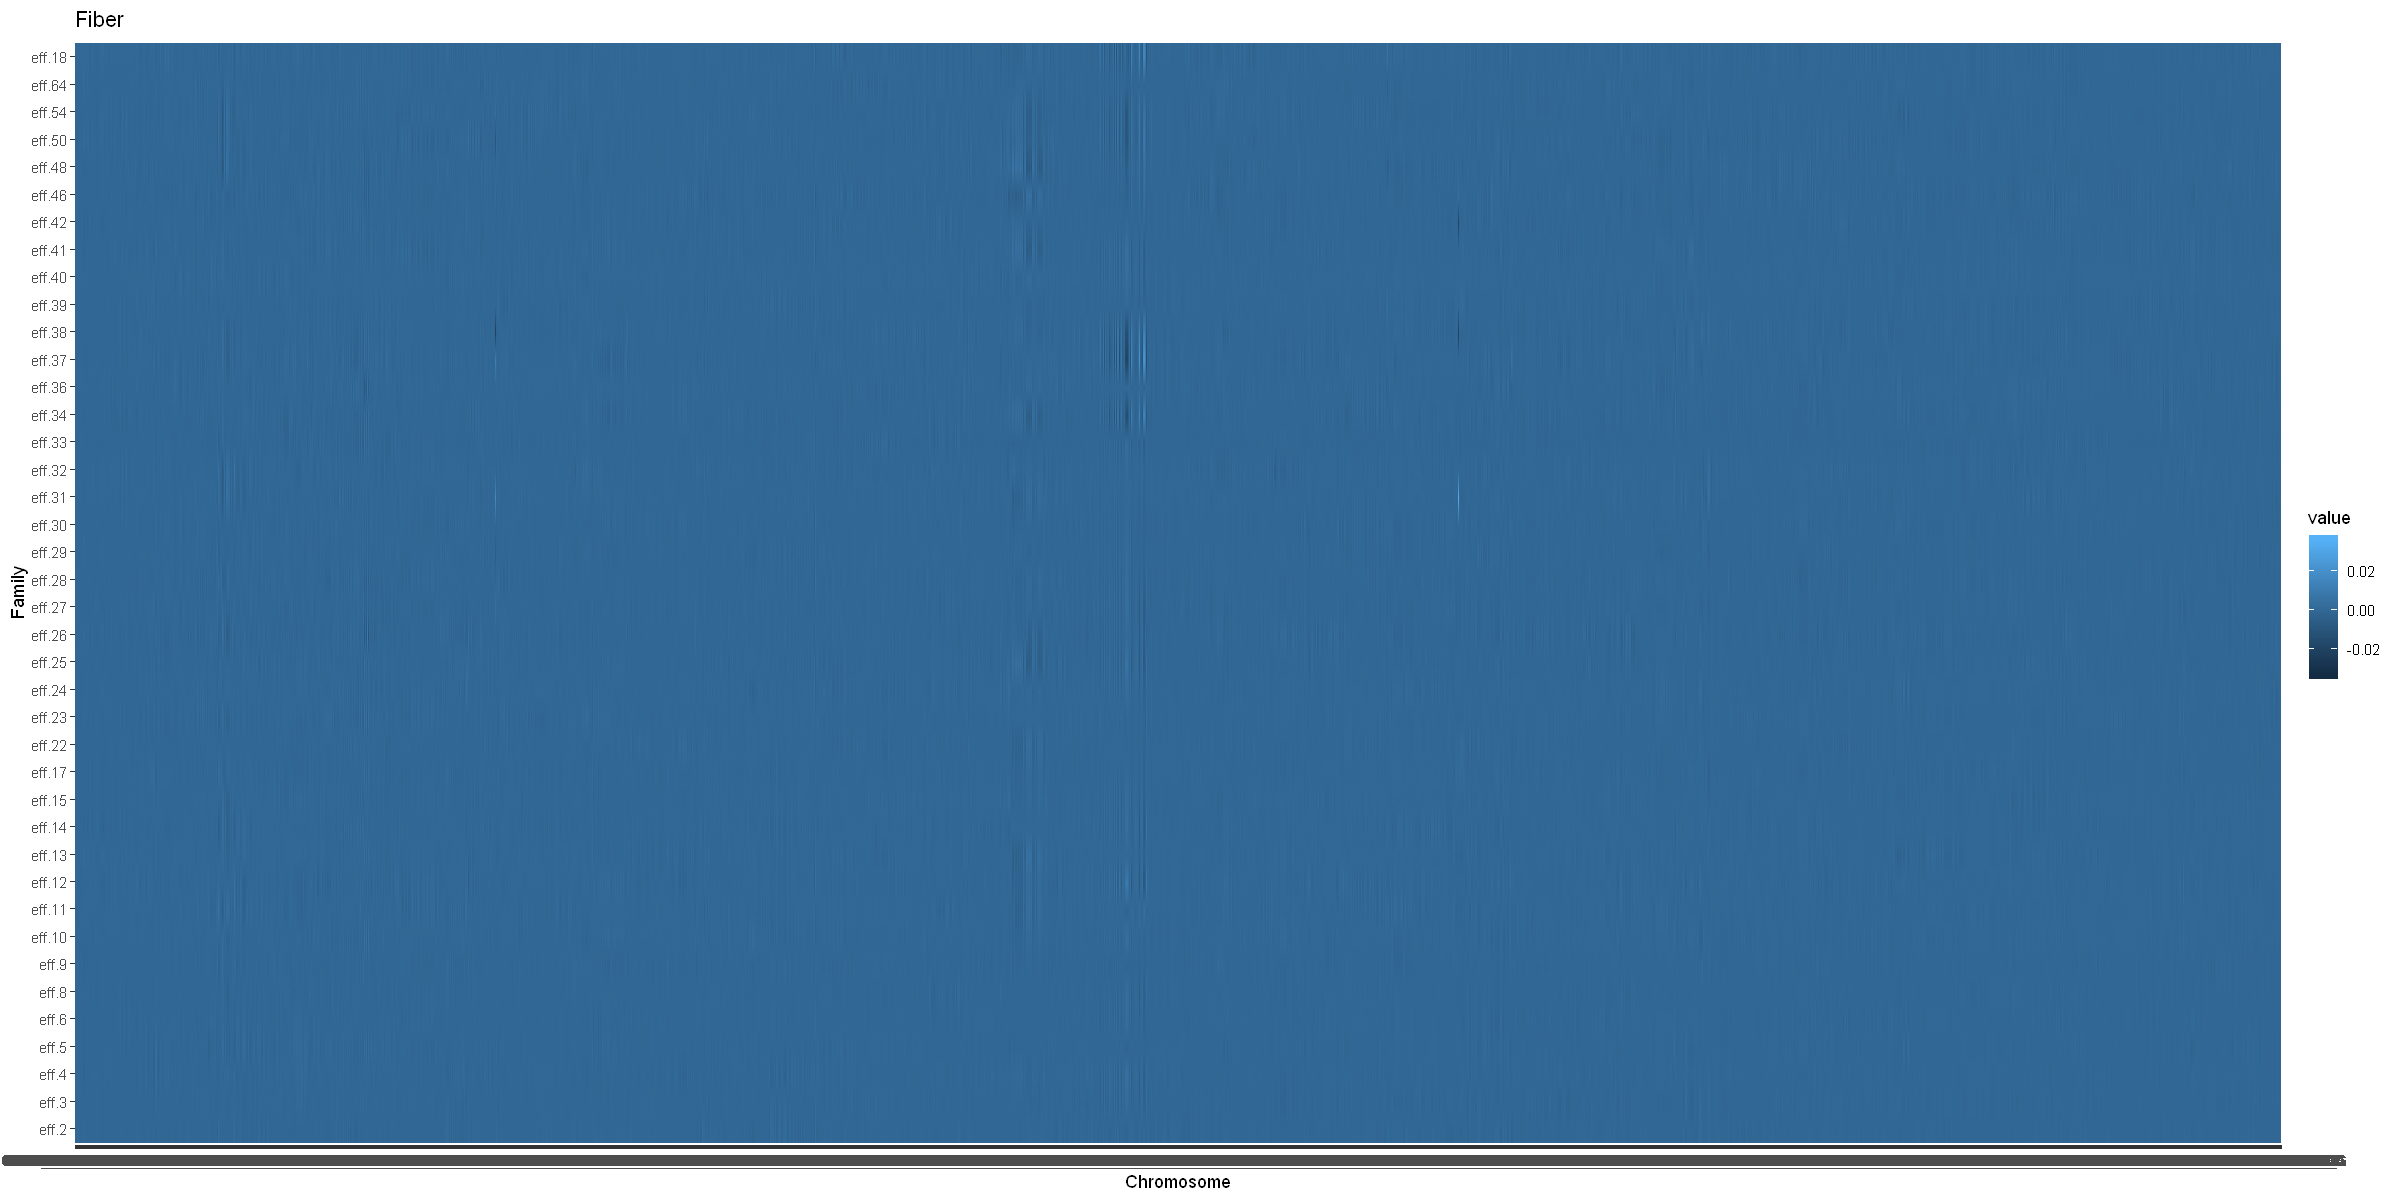

In [42]:
library(dplyr)
library(ggplot2)
library(Hmisc)

options(repr.plot.width=20, repr.plot.height=10)
ggplot(SNPEffectList[[8]], aes(x = Marker_Name, y = variable)) + 
geom_raster(aes(fill = value)) + 
ggtitle(capitalize(names(SNPEffectList)[[8]])) + 
xlab("Chromosome") +
ylab("Family")

Looks horrible. For one thing, the color scale for the fill will definitely have to be changed and another, the labels on the x axis right now are trying to print the names for each of the 4000+ SNPs. This will have to be changed for sure. What I'll try to do with the xaxis labels instead is break up the SNPs into their respective chromosomes. I'll do this by refering back to the TraitGWAS object that I loaded in before. Near the bottom of the object structure, there is a list called "MAP". This object stores the coromosome assignments for each SNP. By tabulating the chromosome assignments I can then refer to the last SNP in each chromosome. Ill show this below...

In [83]:
ChrIDs <- as.data.frame(table(TraitGWAS[[8]]$MAP[, 1]))$Freq
ChrIDs # How many SNPs are in each chromosome

[1] 194 240 207 171 216 238 243 277 169 261 229 172 252 208 209 184 198 319 255
[20] 166

To tell ggplot where to set the axis breaks, I need to give the NAME of the marker where the break should be, not the index.

In [130]:
xbreaks <- c(1, cumsum(ChrIDs)) # I want to position labels at the start of each chromosome
xbreaks

[1]    1  194  434  641  812 1028 1266 1509 1786 1955 2216 2445 2617 2869 3077
[16] 3286 3470 3668 3987 4242 4408

In [45]:
# Now, use these indices to pull their respective SNP names from the TraitGWAS object
xbreaks <- TraitGWAS[[1]]$SNPs[xbreaks[1:20]]
xbreaks

[1] "Gm01_10510009_G_T" "Gm01_9714061_A_G"  "Gm02_9601063_C_A" 
 [4] "Gm03_944915_G_T"   "Gm04_9038964_T_C"  "Gm05_974695_G_A"  
 [7] "Gm06_8110754_A_G"  "Gm07_986872_C_T"   "Gm08_5123392_A_C" 
[10] "Gm09_9870340_A_G"  "Gm10_990215_C_T"   "Gm11_9114922_G_T" 
[13] "Gm12_8443385_A_G"  "Gm13_5793851_A_G"  "Gm14_957494_T_C"  
[16] "Gm15_9962428_G_A"  "Gm16_985860_G_A"   "Gm17_8187342_T_C" 
[19] "Gm18_9935689_C_T"  "Gm19_927666_T_C"

In [46]:
# And finally, make some labels for these breaks
xlabs <- paste("Chromosome", 1:20, sep = " ")
xlabs

[1] "Chromosome 1"  "Chromosome 2"  "Chromosome 3"  "Chromosome 4" 
 [5] "Chromosome 5"  "Chromosome 6"  "Chromosome 7"  "Chromosome 8" 
 [9] "Chromosome 9"  "Chromosome 10" "Chromosome 11" "Chromosome 12"
[13] "Chromosome 13" "Chromosome 14" "Chromosome 15" "Chromosome 16"
[17] "Chromosome 17" "Chromosome 18" "Chromosome 19" "Chromosome 20"

I also need to fix the gradient, preferably so that only large effect SNPs are highlighted. Ill try a new gradient where large negative effets are highlighted in blue, and large positive effects are highlighted in red.

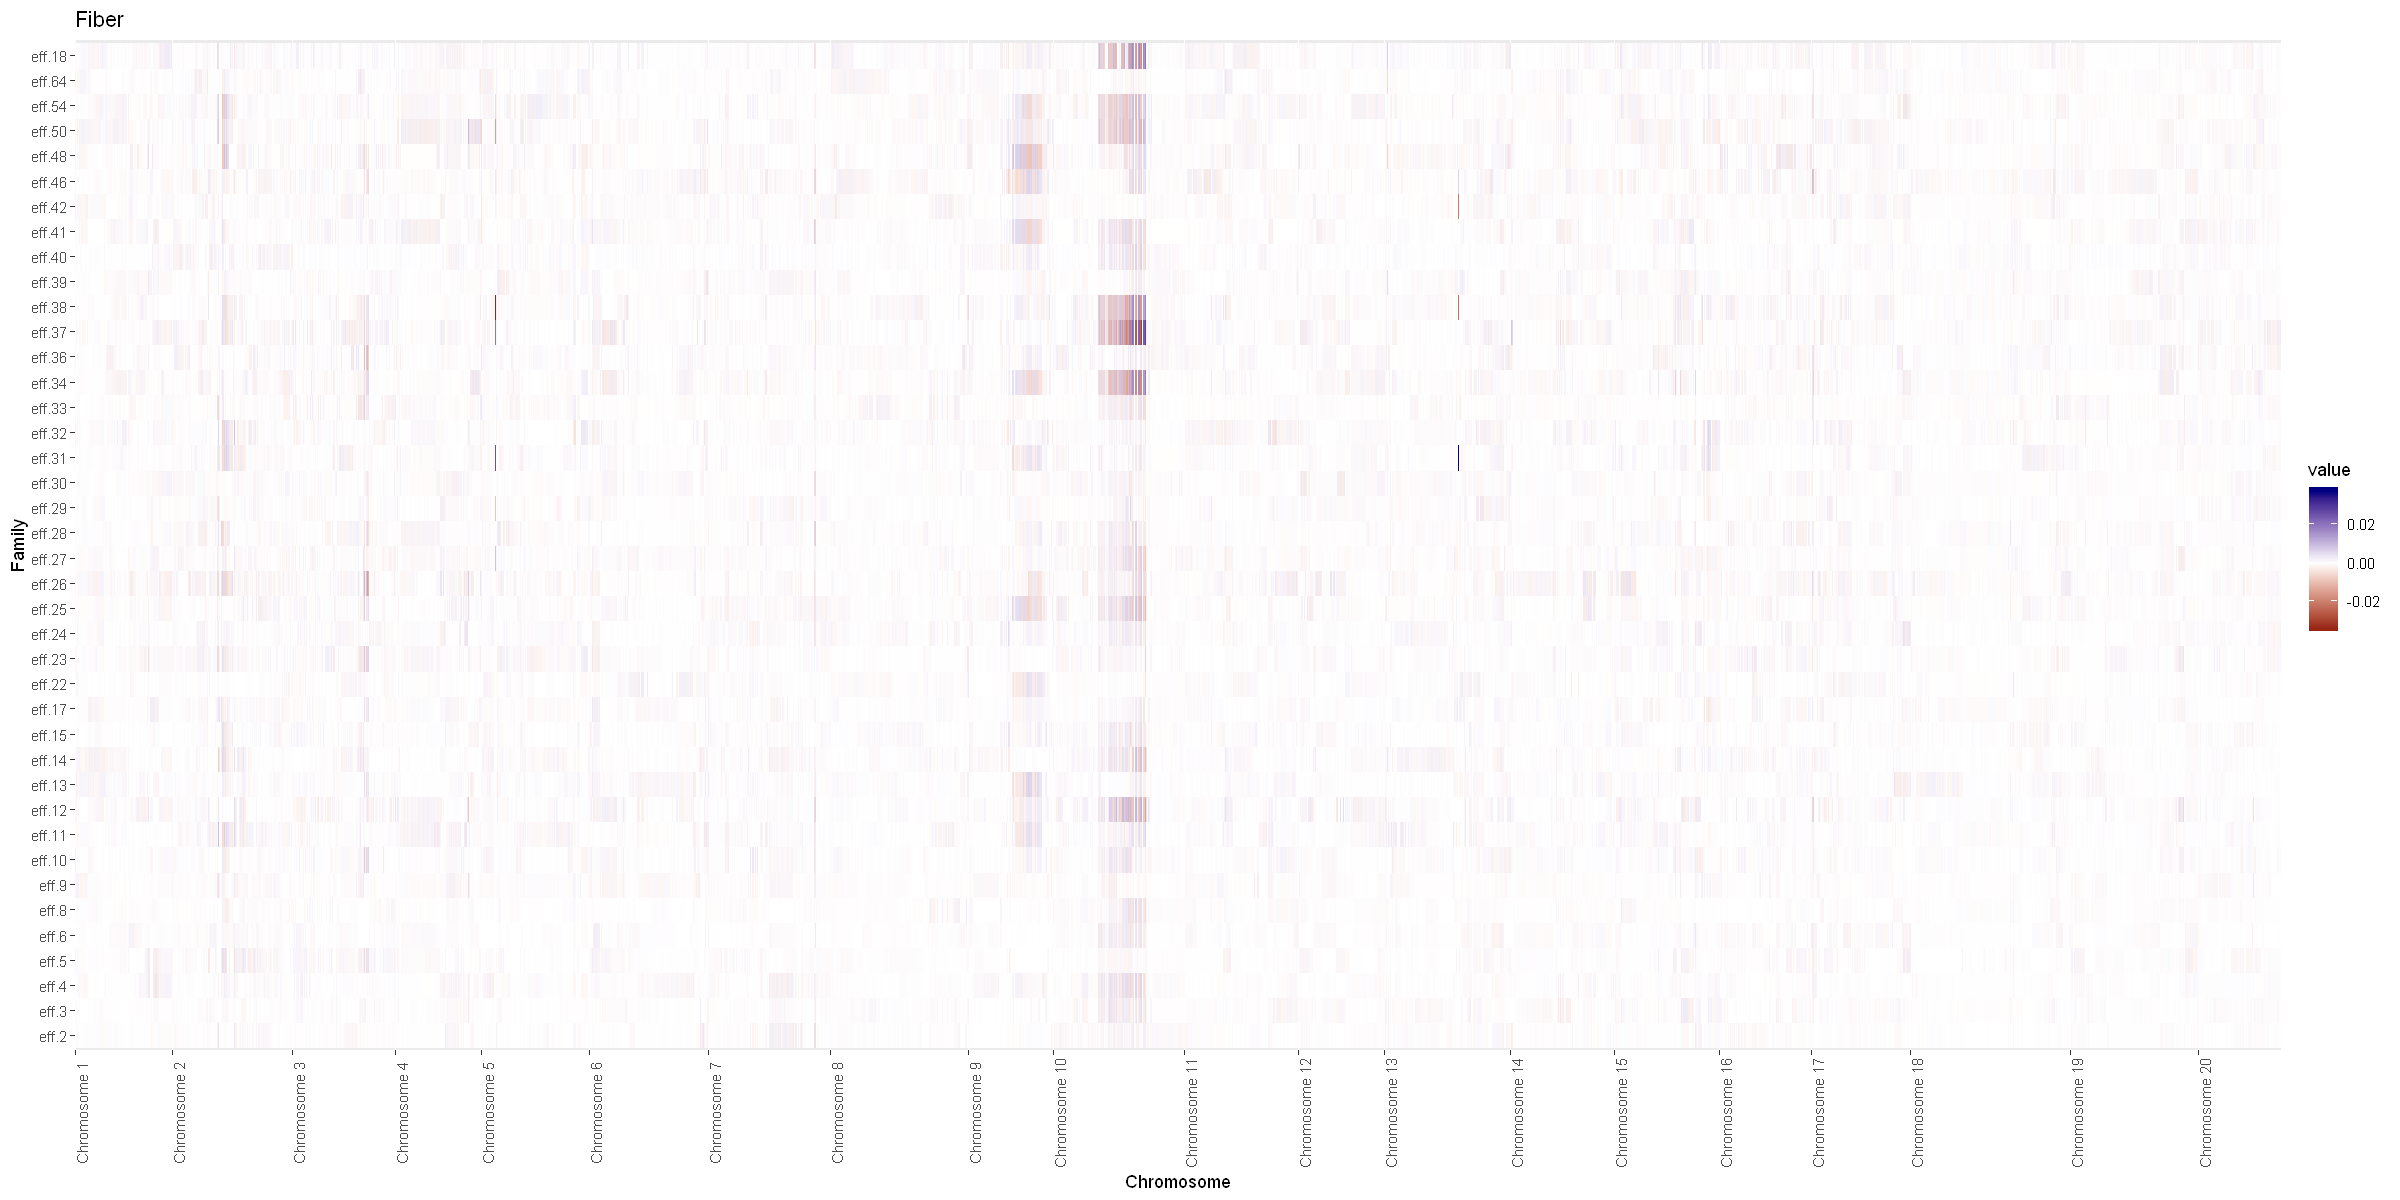

In [85]:
library(dplyr)
library(ggplot2)
library(Hmisc)

# Right now, each SNP name will be plotted as a column name which will really clutter things
# what I want to do instead is label just where each column starts. I can do this using the scale_x_discrete ggplot function
# however, this function needs both labels, and where the labels should go. To find there the labels should go, Ill first find how many
# harkers are on each coromosome, and then find the numeric positions of the last marker on each chromosme using these counts

ChrIDs <- as.data.frame(table(TraitGWAS[[8]]$MAP[, 1]))$Freq # How many markers are on each chromosome

xbreaks <- c(1, cumsum(ChrIDs)) # Sum the counts in that vector to cind the index of the last marker on each chromosome
xbreaks <- TraitGWAS[[1]]$SNPs[xbreaks[1:20]] # exclude the last index
xlabs <- paste("Chromosome", 1:20, sep = " ") # make some labels

mp <- mean(SNPEffectList[[8]]$value, na.rm = TRUE) # midpoint of the SNP effects, used for color gradient

options(repr.plot.width=20, repr.plot.height=10)
ggplot(SNPEffectList[[8]], aes(x = Marker_Name, y = variable)) + 
geom_raster(aes(fill = value)) + 
scale_x_discrete(breaks = xbreaks, labels = xlabs) + 
scale_fill_gradient2(low = "red4", high = "navy", midpoint = mp) +  # New color gradient
theme(axis.text.x = element_text(angle = 90)) + 
ggtitle(capitalize(names(SNPEffectList)[[8]])) + # Add some labels
xlab("Chromosome") +
ylab("Family")

Looks better, but I think I can still do more to better differentiate families, I'll try adding some gridlines. I'll do this using the geom_segment function which needs starting and ending x and y positions. Ill define those with a dataframe

In [86]:
Families <- as.character(unique(SNPEffectList[[8]]$variable))
FMarker <- as.character(TraitGWAS[[1]]$SNPs[[1]])
LMarker <- as.character(TraitGWAS[[1]]$SNPs[[length(TraitGWAS[[1]]$SNPs)]])

MySegments <- data.frame(x = FMarker, y = Families, xend = LMarker, yend = Families)
head(MySegments)

x                 y     xend            yend 
1 Gm01_10510009_G_T eff.2 Gm20_998415_T_G eff.2
2 Gm01_10510009_G_T eff.3 Gm20_998415_T_G eff.3
3 Gm01_10510009_G_T eff.4 Gm20_998415_T_G eff.4
4 Gm01_10510009_G_T eff.5 Gm20_998415_T_G eff.5
5 Gm01_10510009_G_T eff.6 Gm20_998415_T_G eff.6
6 Gm01_10510009_G_T eff.8 Gm20_998415_T_G eff.8

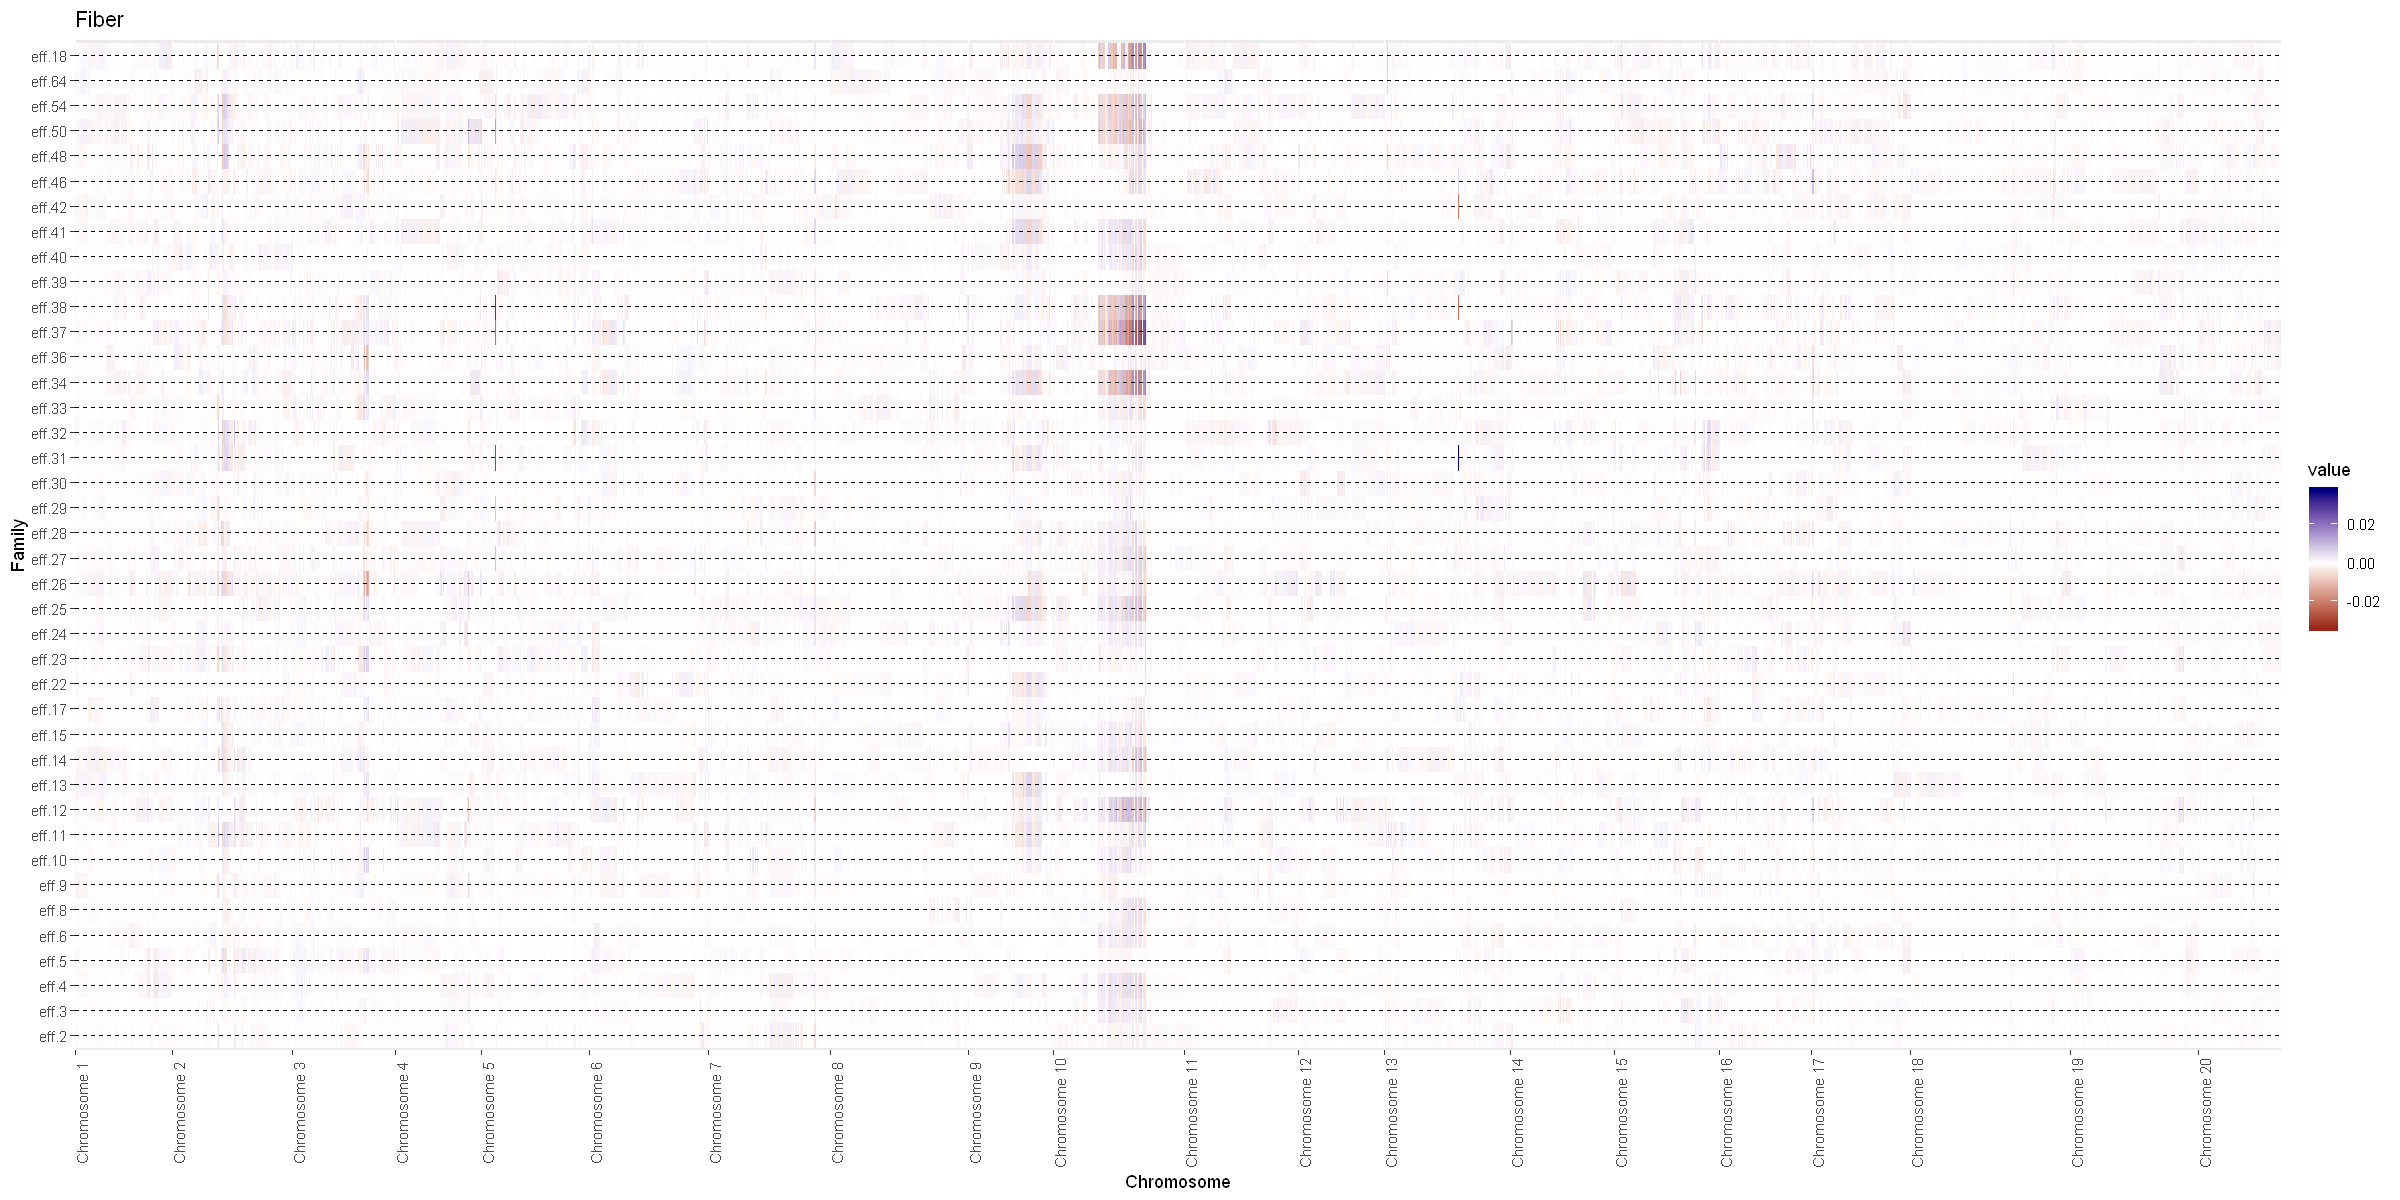

In [87]:
library(dplyr)
library(ggplot2)
library(Hmisc)

ChrIDs <- as.data.frame(table(TraitGWAS[[8]]$MAP[, 1]))$Freq 

xbreaks <- c(1, cumsum(ChrIDs))
xbreaks <- TraitGWAS[[1]]$SNPs[xbreaks[1:20]]
xlabs <- paste("Chromosome", 1:20, sep = " ") 

mp <- mean(SNPEffectList[[8]]$value, na.rm = TRUE) 

options(repr.plot.width=20, repr.plot.height=10)
ggplot(SNPEffectList[[8]], aes(x = Marker_Name, y = variable)) + 
geom_raster(aes(fill = value)) + 
scale_x_discrete(breaks = xbreaks, labels = xlabs) + 
scale_fill_gradient2(low = "red4", high = "navy", midpoint = mp) +
ggtitle(capitalize(names(SNPEffectList)[[8]])) + 
xlab("Chromosome") +
ylab("Family") +
geom_segment(data = MySegments, aes(x, y, xend = xend, yend = yend), size = 0.25, lty = "dashed") + # Add line segments
theme(axis.text.x = element_text(angle = 90))

Starting to look a little better. I want to touch up some of the other aesthetics a bit though, I think I could work with the axes to start. This can be done by giving additional arguments to the theme function. 

Also, at this point some interesting patterns are beginning to emerge. Most families have large effect markers at chromosome 10, but not all. It would be worthwile to find a way to order families based on their effect similarities. I'll try to do that next by calculating "distances" between the correlations of family-level SNP effects.

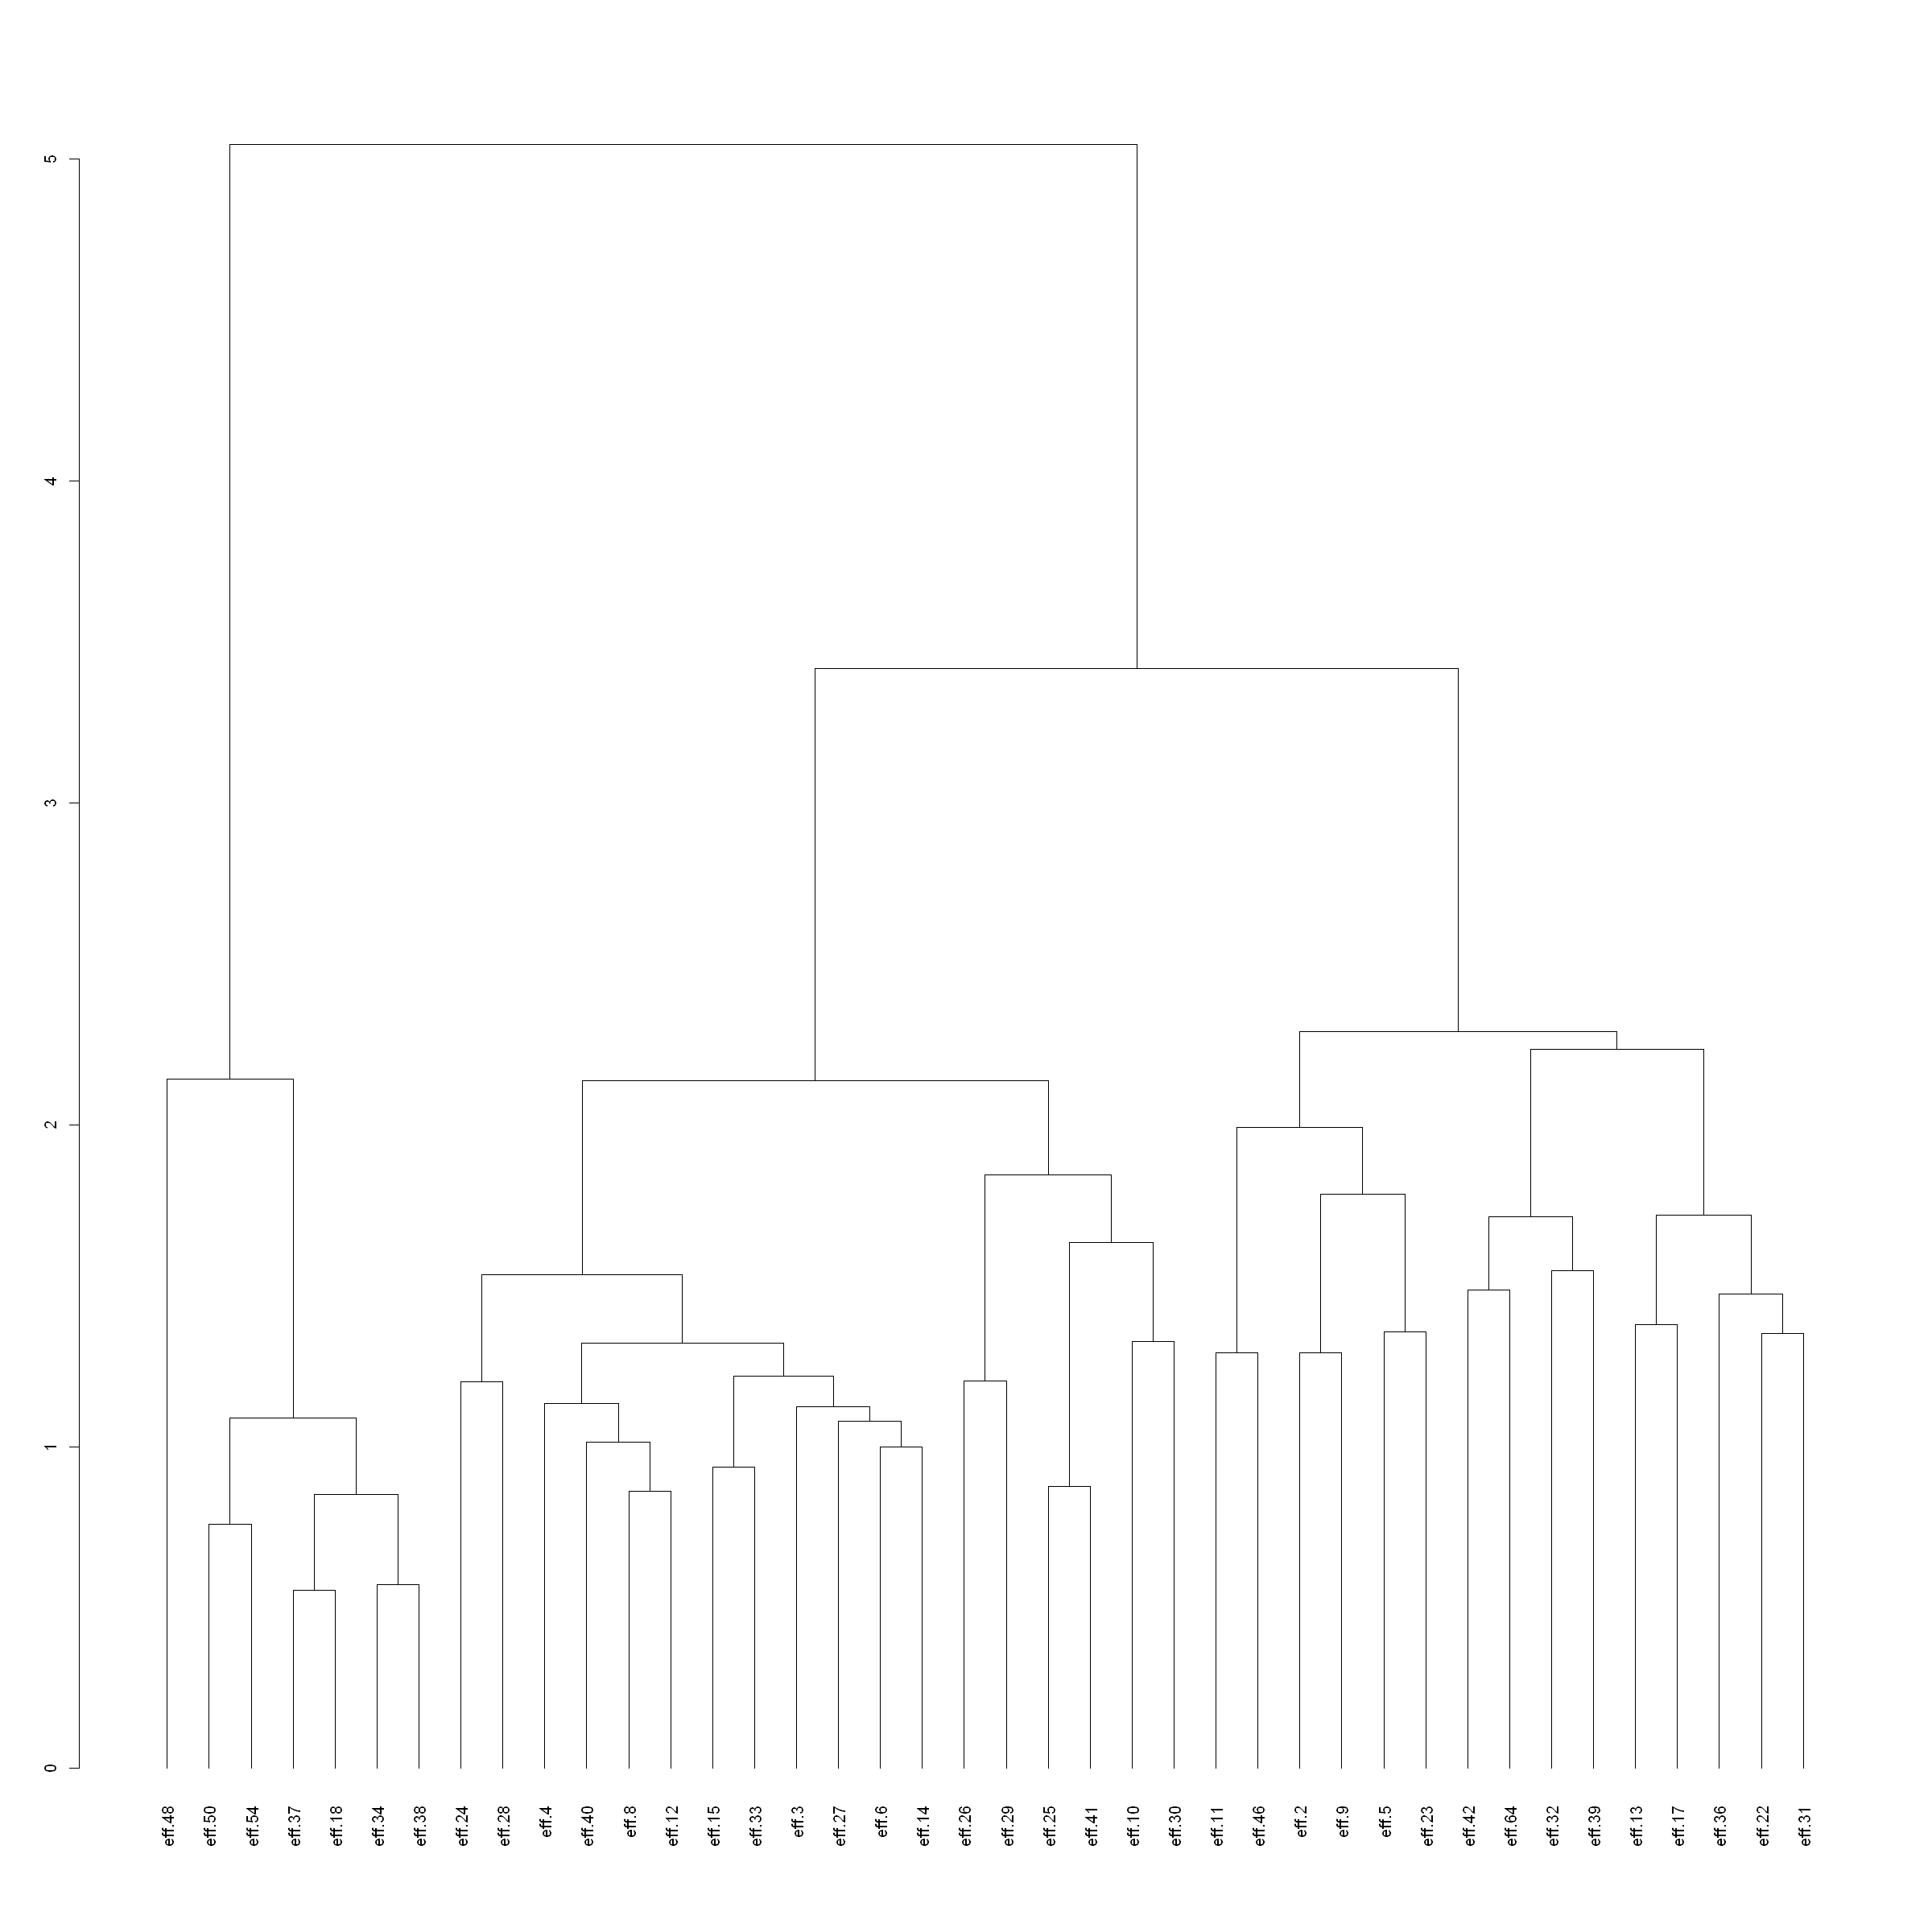

In [90]:
# Clustering families based on SNP effects, trait 8
SNPEffects_T8 <- TraitGWAS[[8]]$PolyTest[, 14:ncol(TraitGWAS[[8]]$PolyTest)]

T8_cor <- cor(SNPEffects_T8) # calculate correlations between families using marker effects
hc <- hclust(dist(T8_cor)) # cluster based on distance of correlations

plot(as.dendrogram(hc))

# Use the order to create a new dataframe of 'ordered' families
T8_Ordered <- SNPEffectList[[8]]
T8_Ordered$variable <- ordered(T8_Ordered$variable, levels = colnames(SNPEffects_T8)[hc$order])

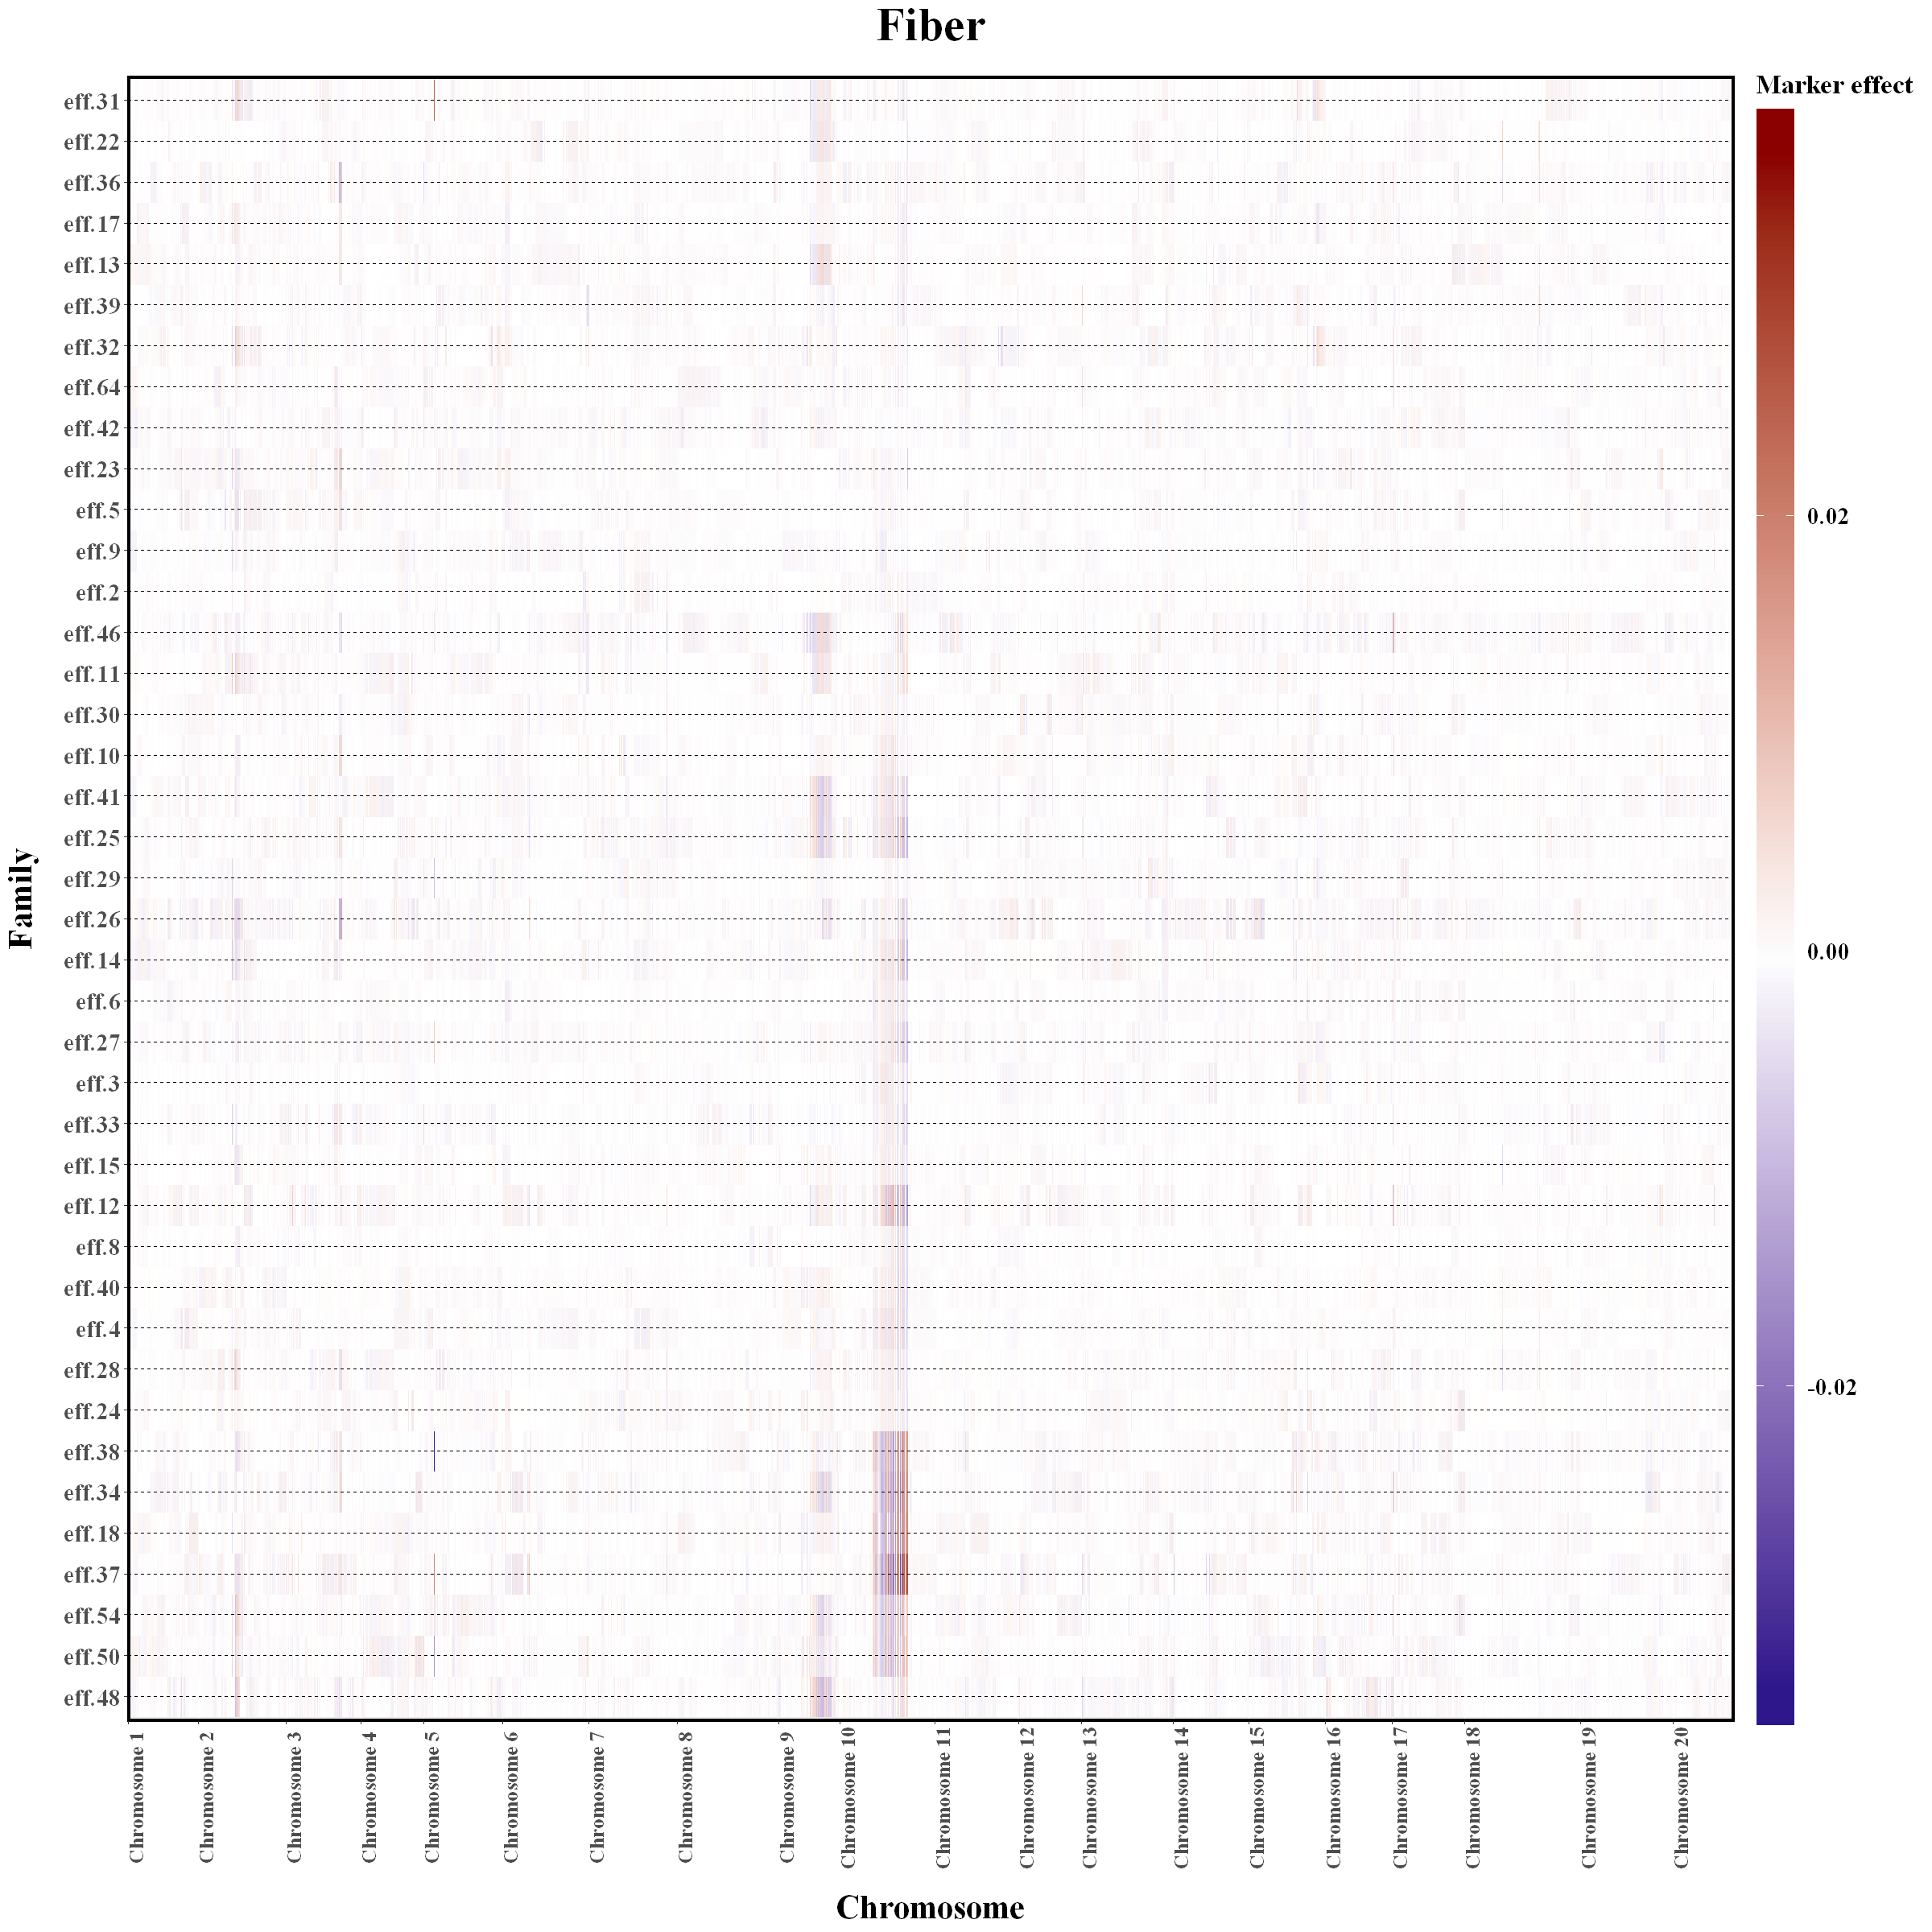

In [106]:
library(dplyr)
library(ggplot2)
library(Hmisc)     # has a function that lets me capitalize words (and a whole lot else too)
library(extrafont) # Font library

# Only needsto run once at the start of a session
# loadfonts(device = "win")

# Right now, each SNP name will be plotted as a column name which will really clutter things
# what I want to do instead is label just where each column starts. I can do this using the scale_x_discrete ggplot function
# however, this function needs both labels, and where the labels should go. To find there the labels should go, Ill first find how many
# harkers are on each coromosome, and then find the numeric positions of the last marker on each chromosme using these counts

ChrIDs <- as.data.frame(table(TraitGWAS[[8]]$MAP[, 1]))$Freq # How many markers are on each chromosome

xbreaks <- c(1, cumsum(ChrIDs)) # Sum the counts in that vector to find the index of the last marker on each chromosome
xbreaks <- TraitGWAS[[1]]$SNPs[xbreaks[1:20]] # exclude the last index
xlabs <- paste("Chromosome", 1:20, sep = " ") # make some labels

mp <- mean(SNPEffectList[[8]]$value, na.rm = TRUE) # midpoint of the SNP effects, used for color gradient

options(repr.plot.width=20, repr.plot.height=20) # Increase plot height to better differentiate families
ggplot(T8_Ordered, aes(x = Marker_Name, y = variable)) + 
geom_raster(aes(fill = value)) + 
scale_x_discrete(breaks = xbreaks, labels = xlabs) + 
scale_fill_gradient2(low = "navy", high = "red4", midpoint = mp, name = "Marker effect") + 
ggtitle(capitalize(names(SNPEffectList)[[8]])) + # Add some labels
xlab("Chromosome") +
ylab("Family") +
geom_segment(data = MySegments, aes(x, y, xend = xend, yend = yend), size = 0.25, lty = "dashed") + 
theme(axis.text.x = element_text(angle = 90, size = 15, face = "bold", family = "Times New Roman"),
      axis.text.y = element_text(size = 18, face = "bold", family = "Times New Roman"),
      legend.key.height = unit(8.5, "cm"),
      legend.key.width = unit(1, "cm"),
      legend.text = element_text(size = 18, face = "bold", family = "Times New Roman"),
      legend.title = element_text(size = 20, face = "bold", family = "Times New Roman"),
      panel.border = element_rect(colour = "black", fill=NA, size=2),
      axis.title.x = element_text(size = 25, face = "bold", margin = margin(t = 20, r = 0, b = 0, l = 0), family = "Times New Roman"),
     axis.title.y = element_text(size = 25, face = "bold", margin = margin(t = 0, r = 20, b = 0, l = 0), family = "Times New Roman"),
     plot.title = element_text(size = 35, face = "bold", family = "Times New Roman", hjust = 0.5,  margin = margin(t = 0, r = 0, b = 20, l = 0)))

Looking better. Now say I dont care about the direction of the effect, just if there is an effect or not. Converting effects to absolute values should do the trick. I'll recalculate this and change the gradient.

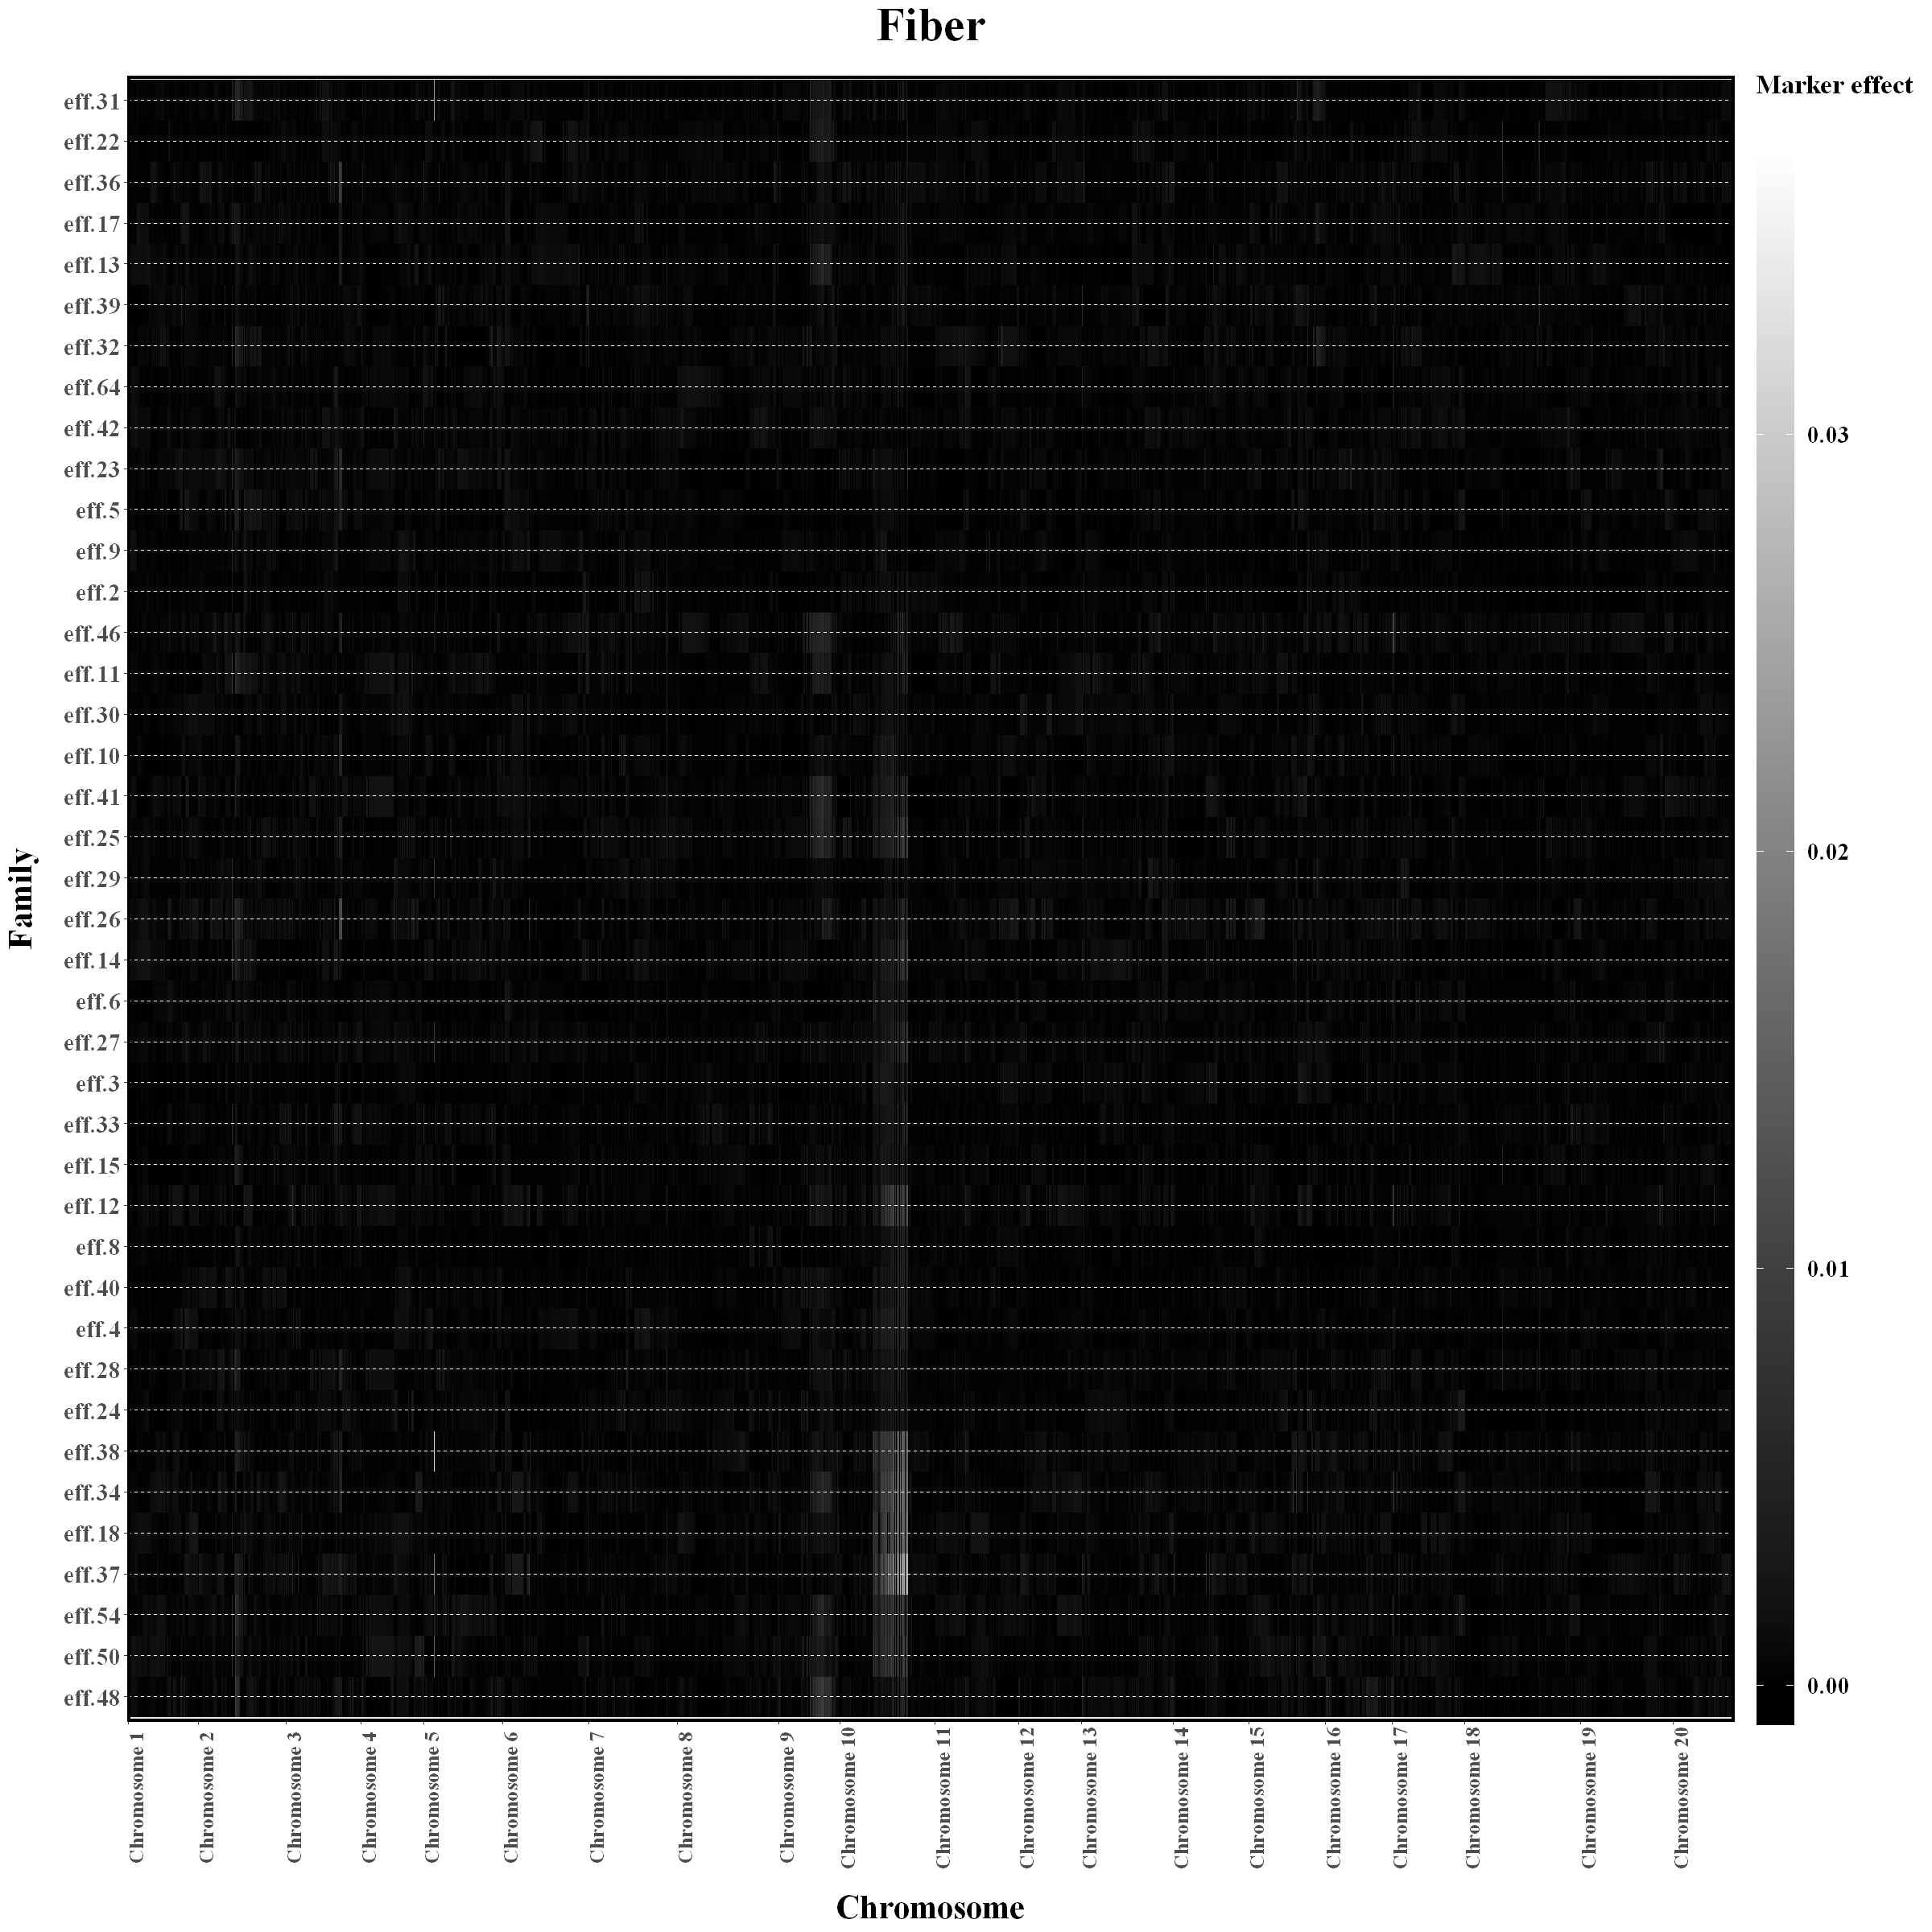

In [115]:
T8_Ordered_Abs <- T8_Ordered
T8_Ordered_Abs$value <- abs(T8_Ordered_Abs$value) # Absolute value of marker effect

options(repr.plot.width=20, repr.plot.height=20)
ggplot(T8_Ordered_Abs, aes(x = Marker_Name, y = variable)) + 
geom_raster(aes(fill = value)) + 
scale_x_discrete(breaks = xbreaks, labels = xlabs) + 
scale_fill_gradient(low = "black", high = "white", name = "Marker effect") +  # New color gradient
ggtitle(capitalize(names(SNPEffectList)[[8]])) +
xlab("Chromosome") +
ylab("Family") +
geom_segment(data = MySegments, aes(x, y, xend = xend, yend = yend), size = 0.25, lty = "dashed", col = "white") + 
theme(axis.text.x = element_text(angle = 90, size = 15, face = "bold", family = "Times New Roman"),
      axis.text.y = element_text(size = 18, face = "bold", family = "Times New Roman"),
      legend.key.height = unit(8.5, "cm"),
      legend.key.width = unit(1, "cm"),
      legend.text = element_text(size = 18, face = "bold", family = "Times New Roman"),
      legend.title = element_text(size = 20, face = "bold", family = "Times New Roman"),
      panel.border = element_rect(colour = "black", fill=NA, size=2),
      axis.title.x = element_text(size = 25, face = "bold", margin = margin(t = 20, r = 0, b = 0, l = 0), family = "Times New Roman"),
     axis.title.y = element_text(size = 25, face = "bold", margin = margin(t = 0, r = 20, b = 0, l = 0), family = "Times New Roman"),
     plot.title = element_text(size = 35, face = "bold", family = "Times New Roman", hjust = 0.5,  margin = margin(t = 0, r = 0, b = 20, l = 0)))

So there you have it. I wanted to make a plot like this so that I could more quickly find patterns in my data that I probably would never have picked up on if I'd just looked at it in a table or with some summary statistics. My goal here was to make more of an exploratory plot than anything explanatory, something that could lead you to ask more questions about the data, and why might you see the patterns that you do. From this plot, I noticed that the effects of alleles were not constant across my populations, I can see this in the differences in marker effects as you move down the plot where those positioned near the bottom tend to have large effect alleles on chromosomes 9 and 10, while those at the top do not. This is not unexpected as the soybean lines in this population were secifically chosen to provide a diverse set of alleles for analysis in GWAS, but it would be interesting to look into why exactly subgroups of the populations differ in terms of their marker effects. 

Finally, the steps I repeated to make the plot for the one trait (fiber) can be extended to the remaining traits in my data, I'll do that below.

In [122]:
# Cluster families based on marker effect patterns
for(i in 1:length(TraitGWAS)){
    TraitFrame <- TraitGWAS[[i]]$PolyTest[, 14:ncol(TraitGWAS[[i]]$PolyTest)]
    TraitFrame <- cor(TraitFrame)
    hc <- hclust(dist(TraitFrame)) # cluster base on distance of correlations
    
    SNPEffectList[[i]]$variable <- ordered(SNPEffectList[[i]]$variable, levels = colnames(TraitFrame)[hc$order])
}

PlotList <- vector("list", length = length(TraitGWAS))
names(PlotList) <- names(TraitGWAS)
for(i in 1:length(PlotList)){
    
    ChrIDs <- as.data.frame(table(TraitGWAS[[i]]$MAP[, 1]))$Freq # How many markers are on each chromosome

xbreaks <- c(1, cumsum(ChrIDs)) # Sum the counts in that vector to cind the index of the last marker on each chromosome
xbreaks <- TraitGWAS[[i]]$SNPs[xbreaks[1:20]] # exclude the last index
xlabs <- paste("Chromosome", 1:20, sep = " ") # make some labels

mp <- mean(SNPEffectList[[i]]$value, na.rm = TRUE) # midpoint of the SNP effects, used for color gradient

options(repr.plot.width=20, repr.plot.height=20)
PlotList[[i]] <- ggplot(SNPEffectList[[i]], aes(x = Marker_Name, y = variable)) + 
geom_raster(aes(fill = value)) + 
scale_x_discrete(breaks = xbreaks, labels = xlabs) + 
scale_fill_gradient2(low = "navy", high = "red4", midpoint = mp, name = "Marker effect") +  # New color gradient
ggtitle(capitalize(names(SNPEffectList)[[i]])) + # Add some labels
xlab("Chromosome") +
ylab("Family") +
geom_segment(data = MySegments, aes(x, y, xend = xend, yend = yend), size = 0.25, lty = "dashed") + 
theme(axis.text.x = element_text(angle = 90, size = 15, face = "bold", family = "Times New Roman"),
      axis.text.y = element_text(size = 18, face = "bold", family = "Times New Roman"),
      legend.key.height = unit(8.5, "cm"),
      legend.key.width = unit(1, "cm"),
      legend.text = element_text(size = 18, face = "bold", family = "Times New Roman"),
      legend.title = element_text(size = 20, face = "bold", family = "Times New Roman"),
      panel.border = element_rect(colour = "black", fill=NA, size=2),
      axis.title.x = element_text(size = 25, face = "bold", margin = margin(t = 20, r = 0, b = 0, l = 0), family = "Times New Roman"),
     axis.title.y = element_text(size = 25, face = "bold", margin = margin(t = 0, r = 20, b = 0, l = 0), family = "Times New Roman"),
     plot.title = element_text(size = 35, face = "bold", family = "Times New Roman", hjust = 0.5,  margin = margin(t = 0, r = 0, b = 20, l = 0)))
    
}


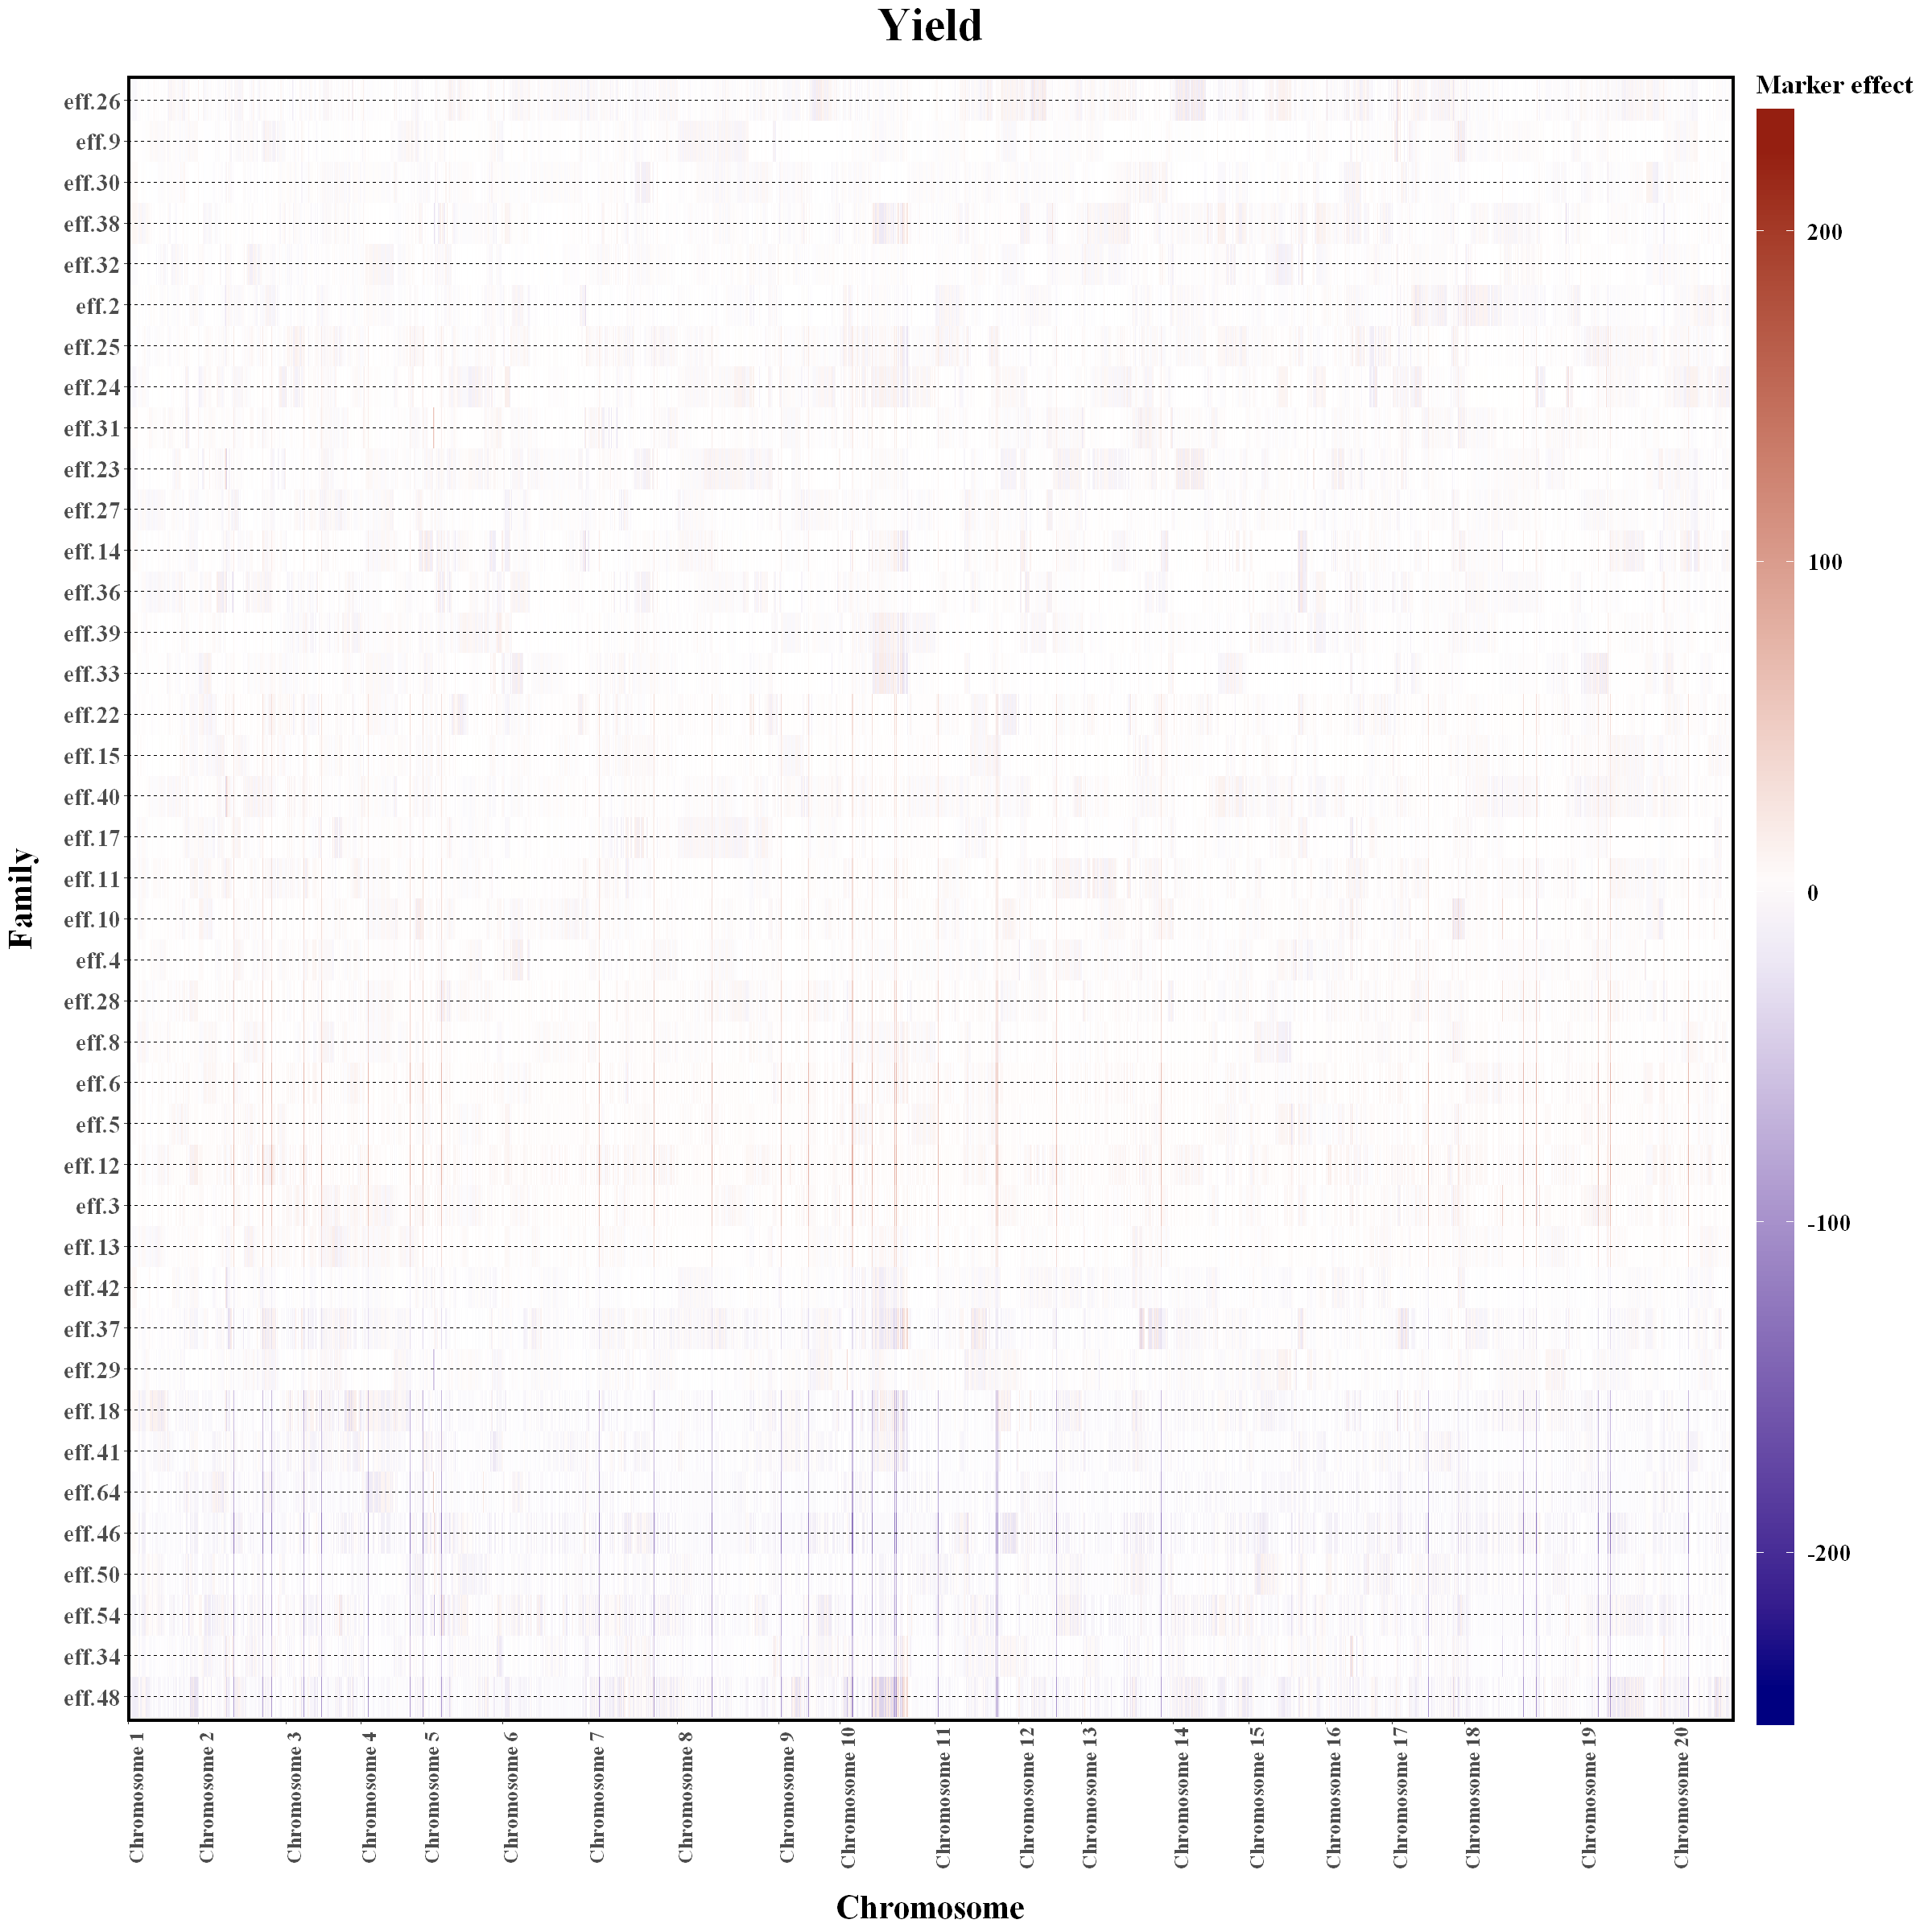

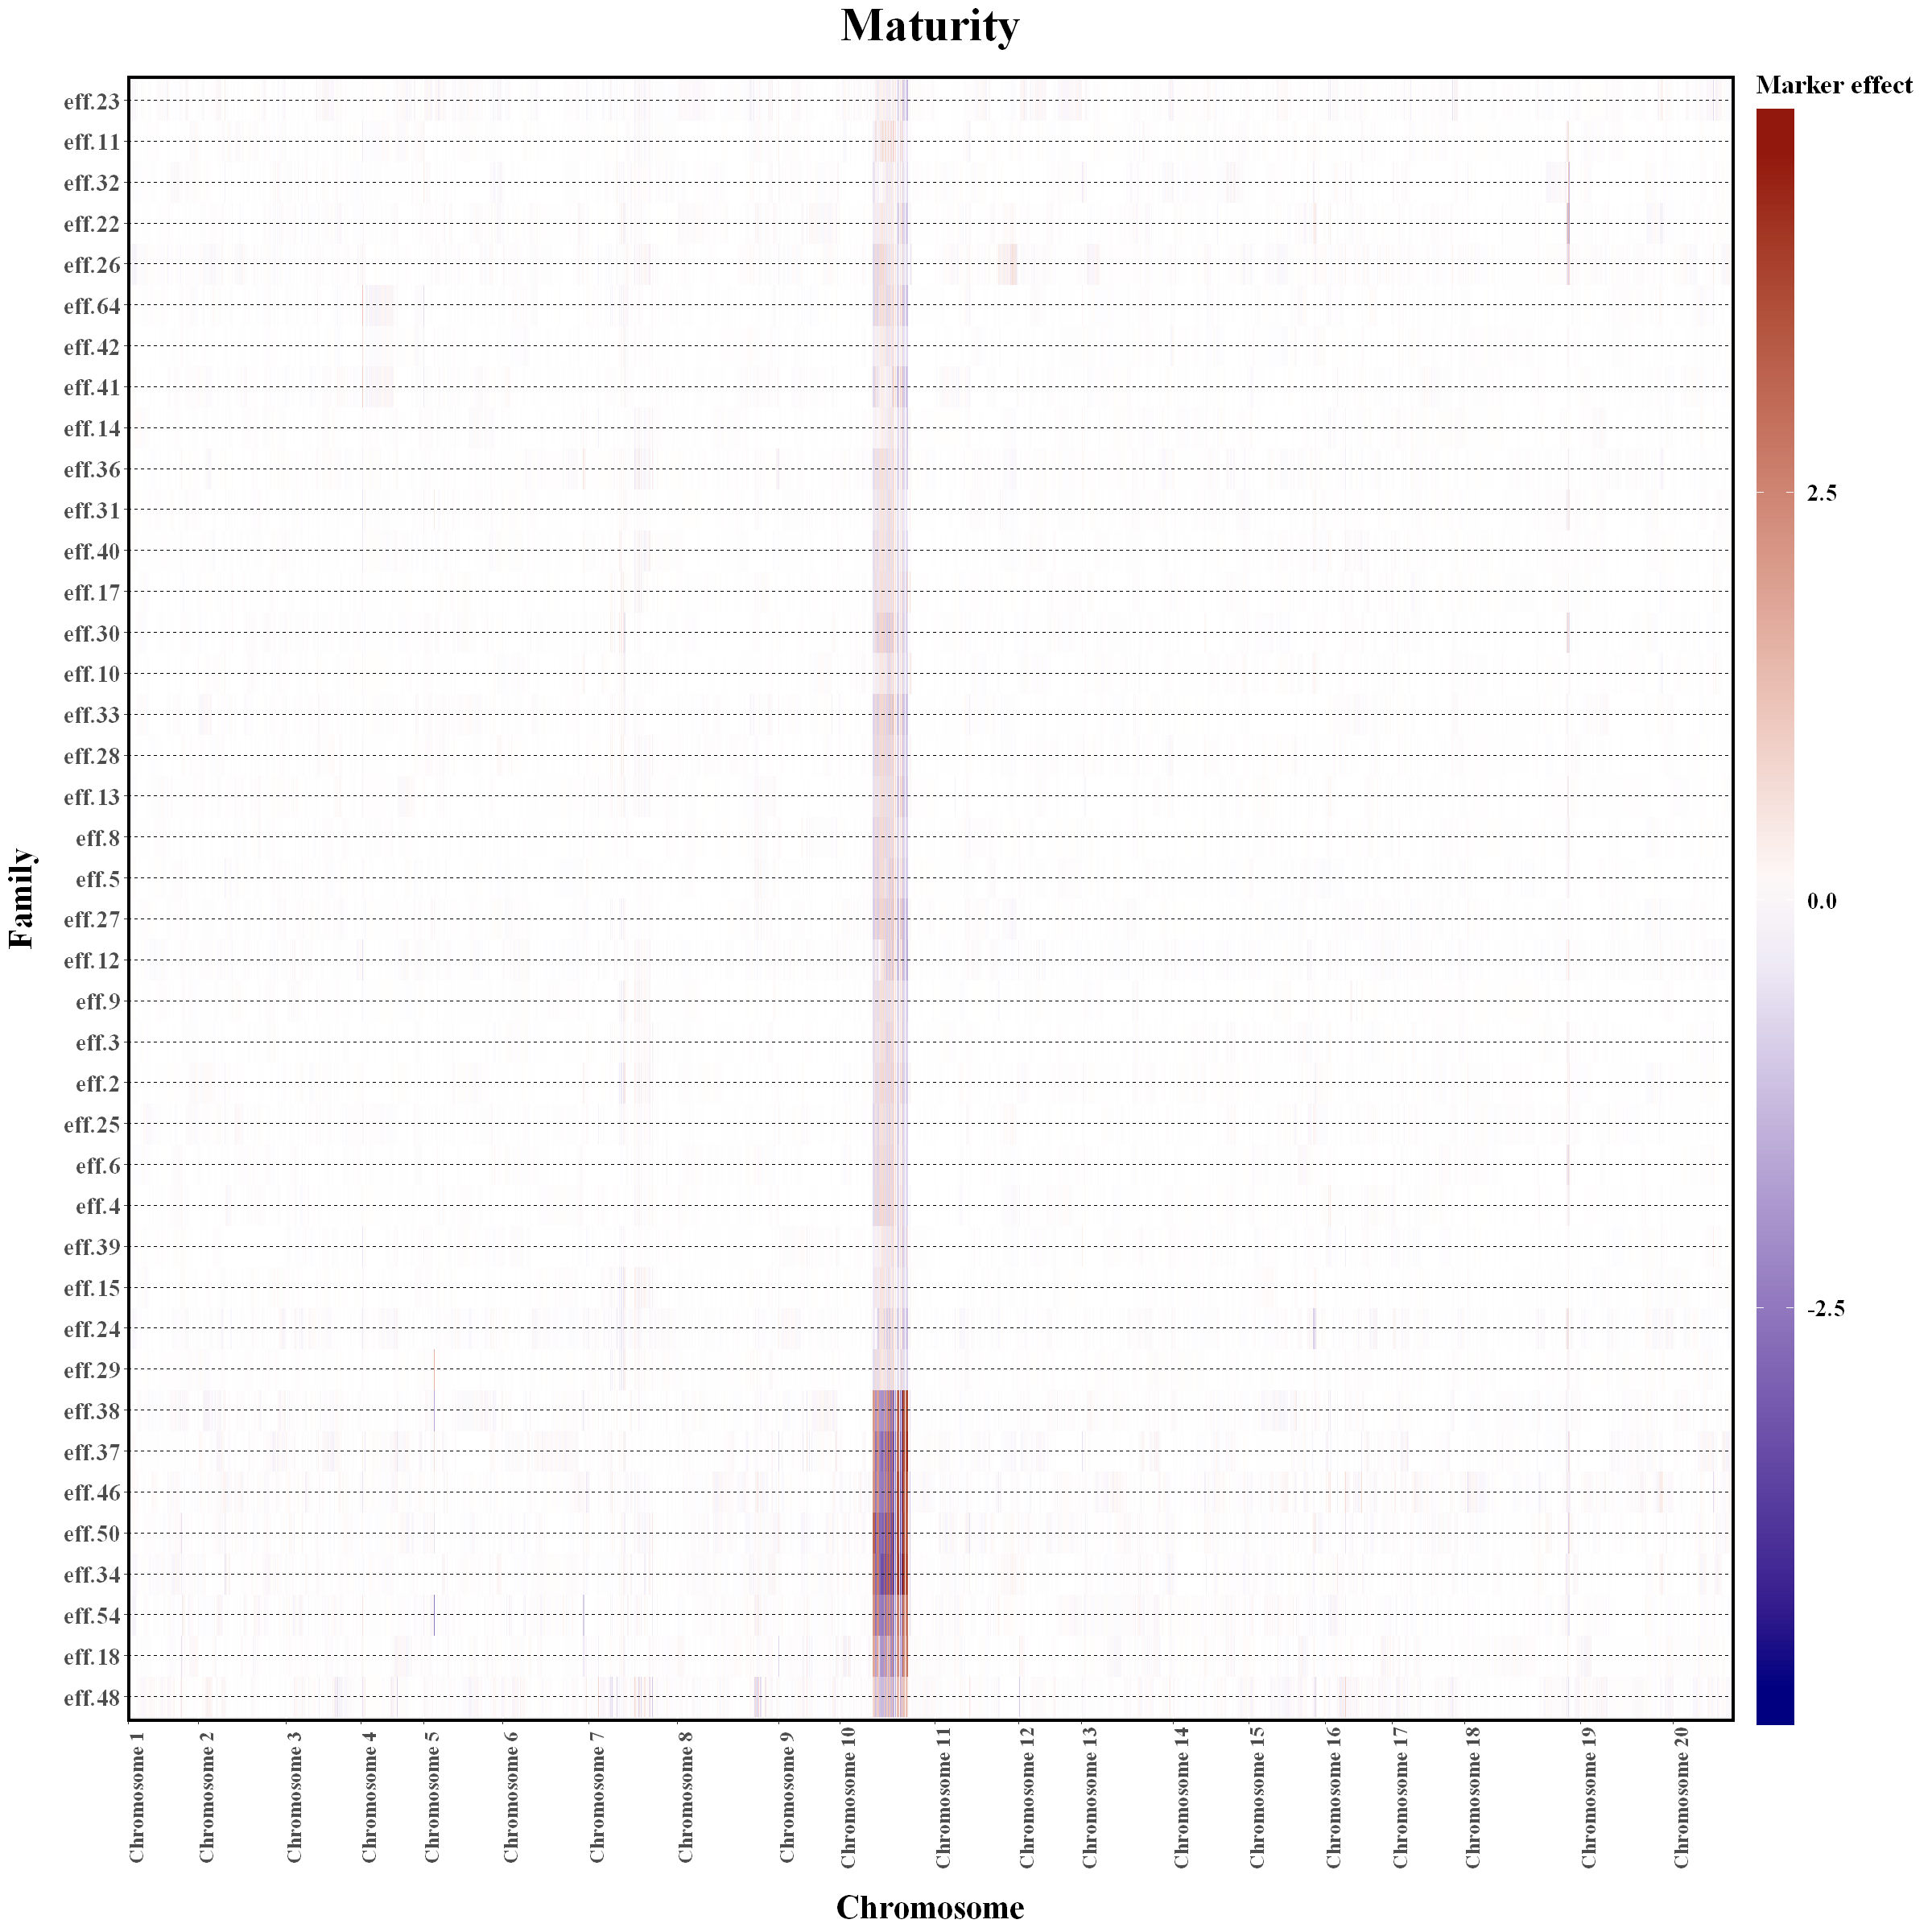

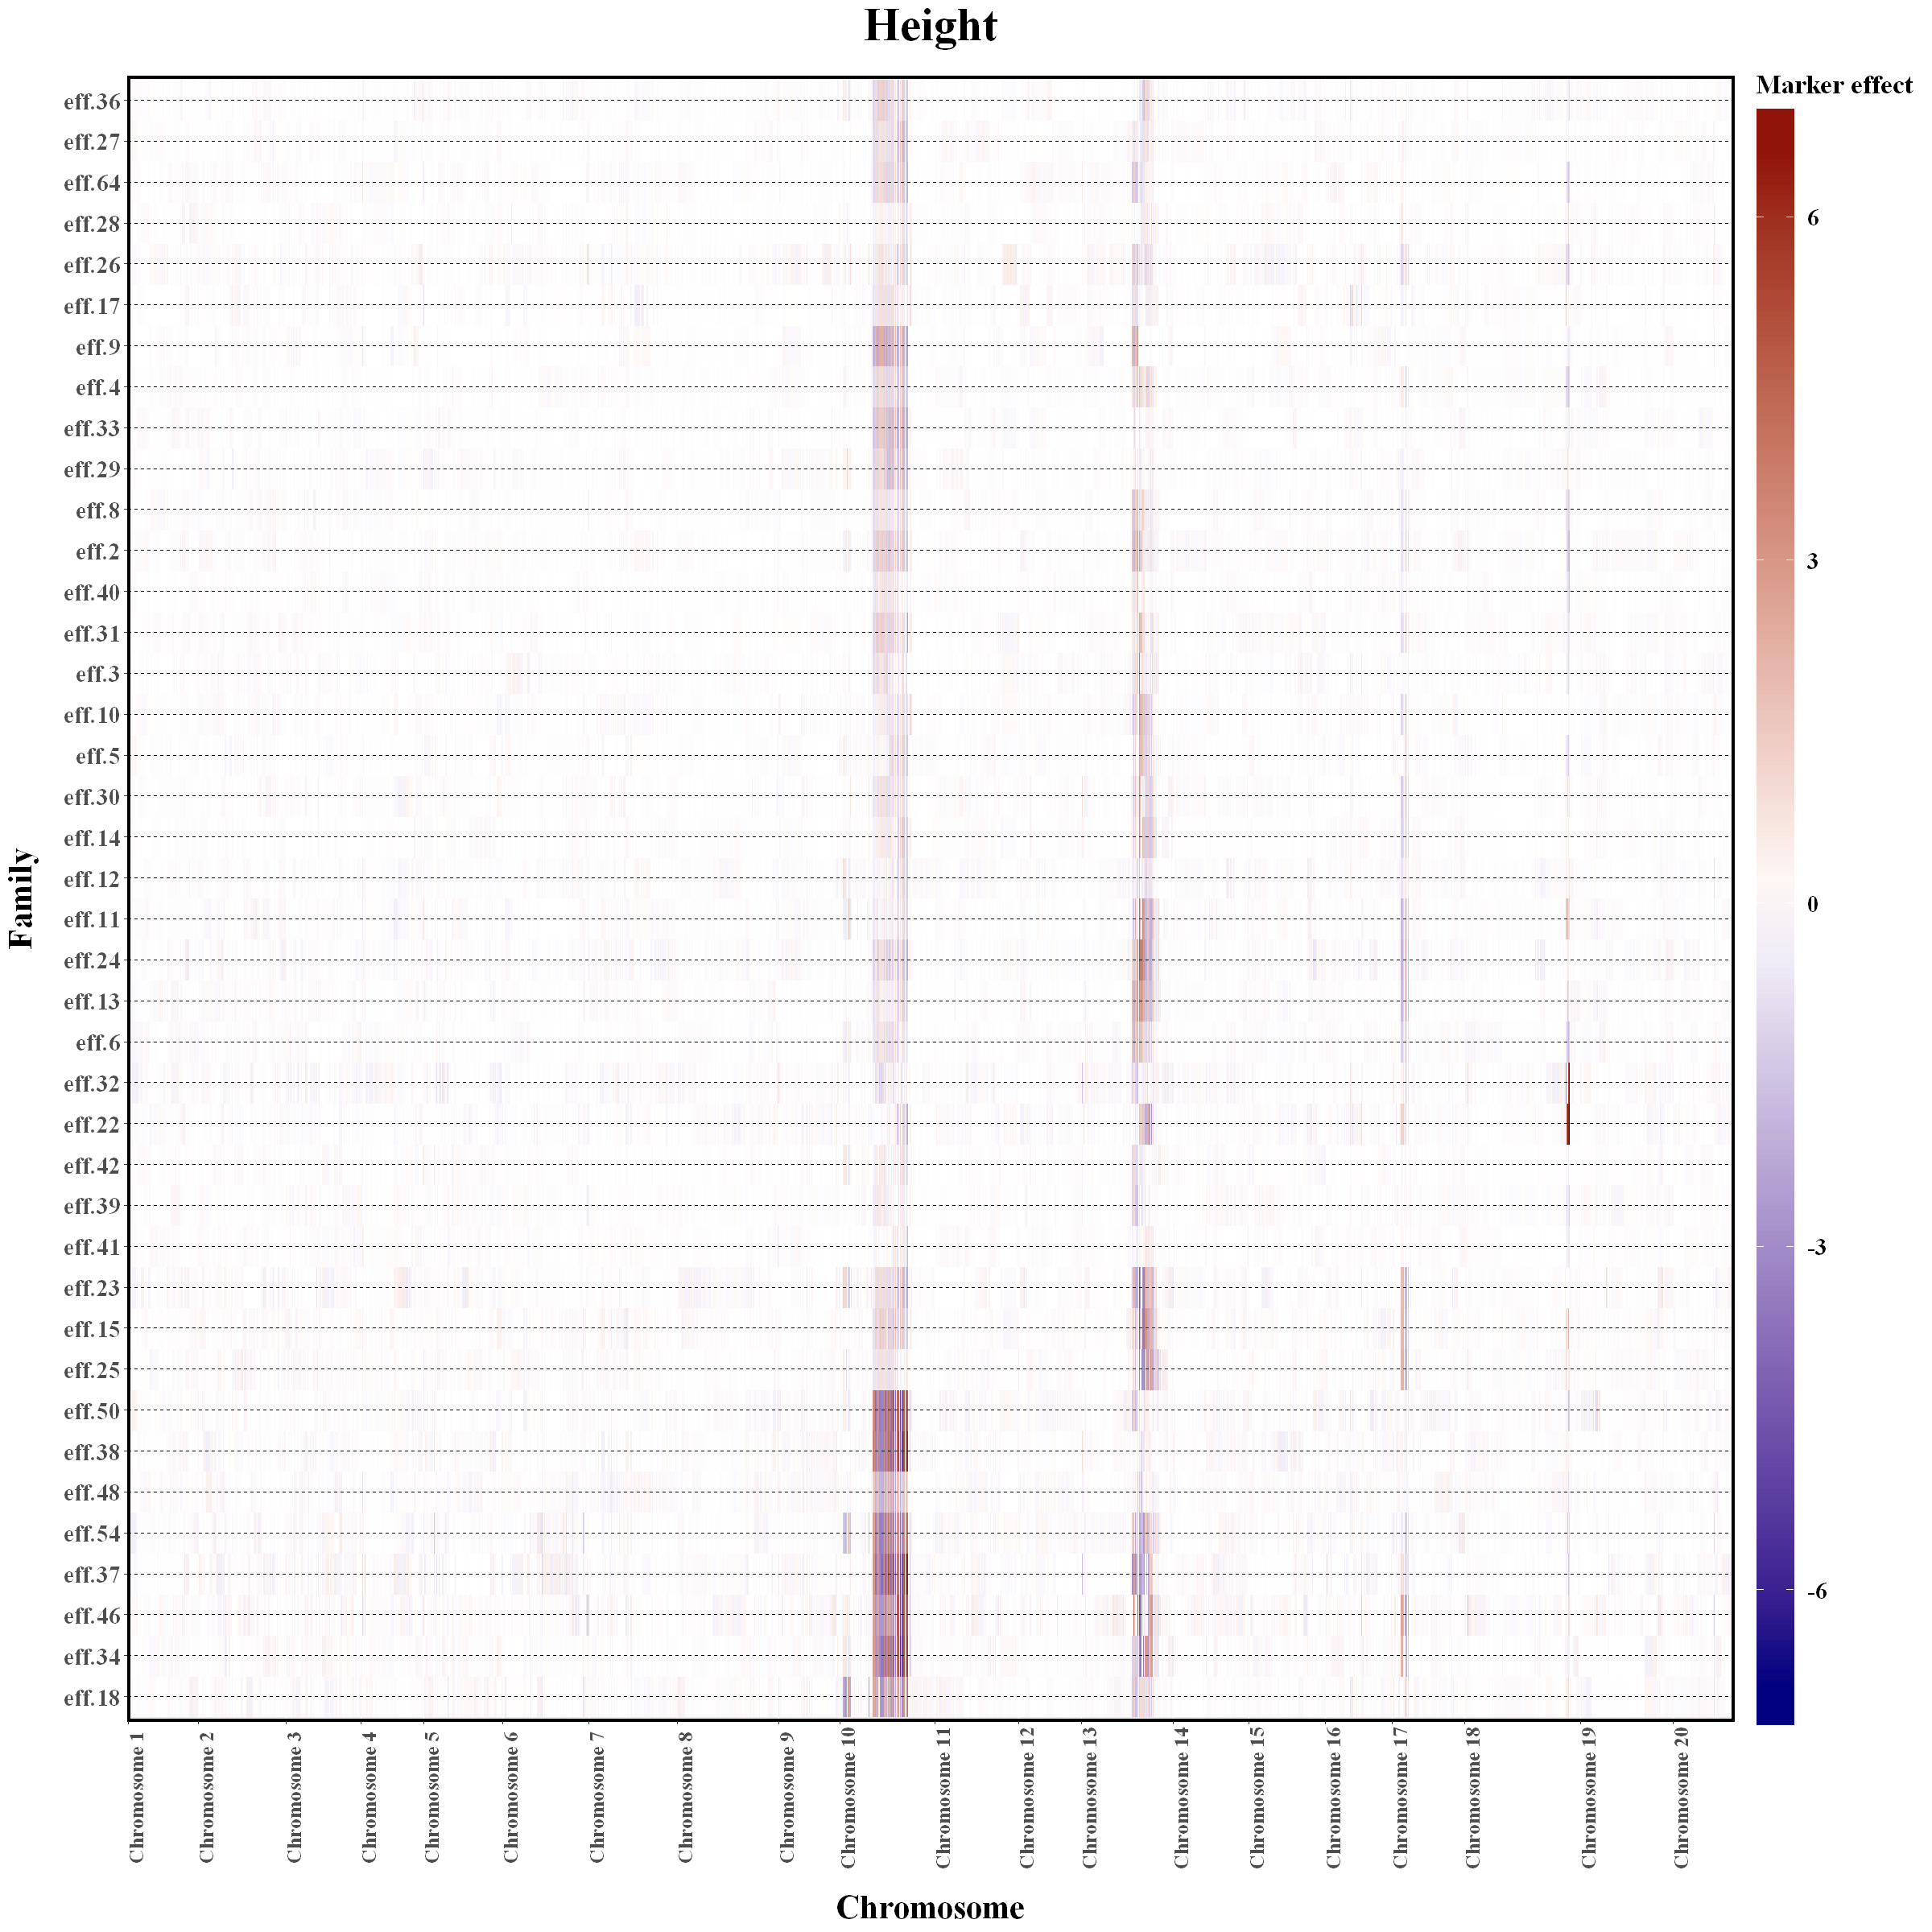

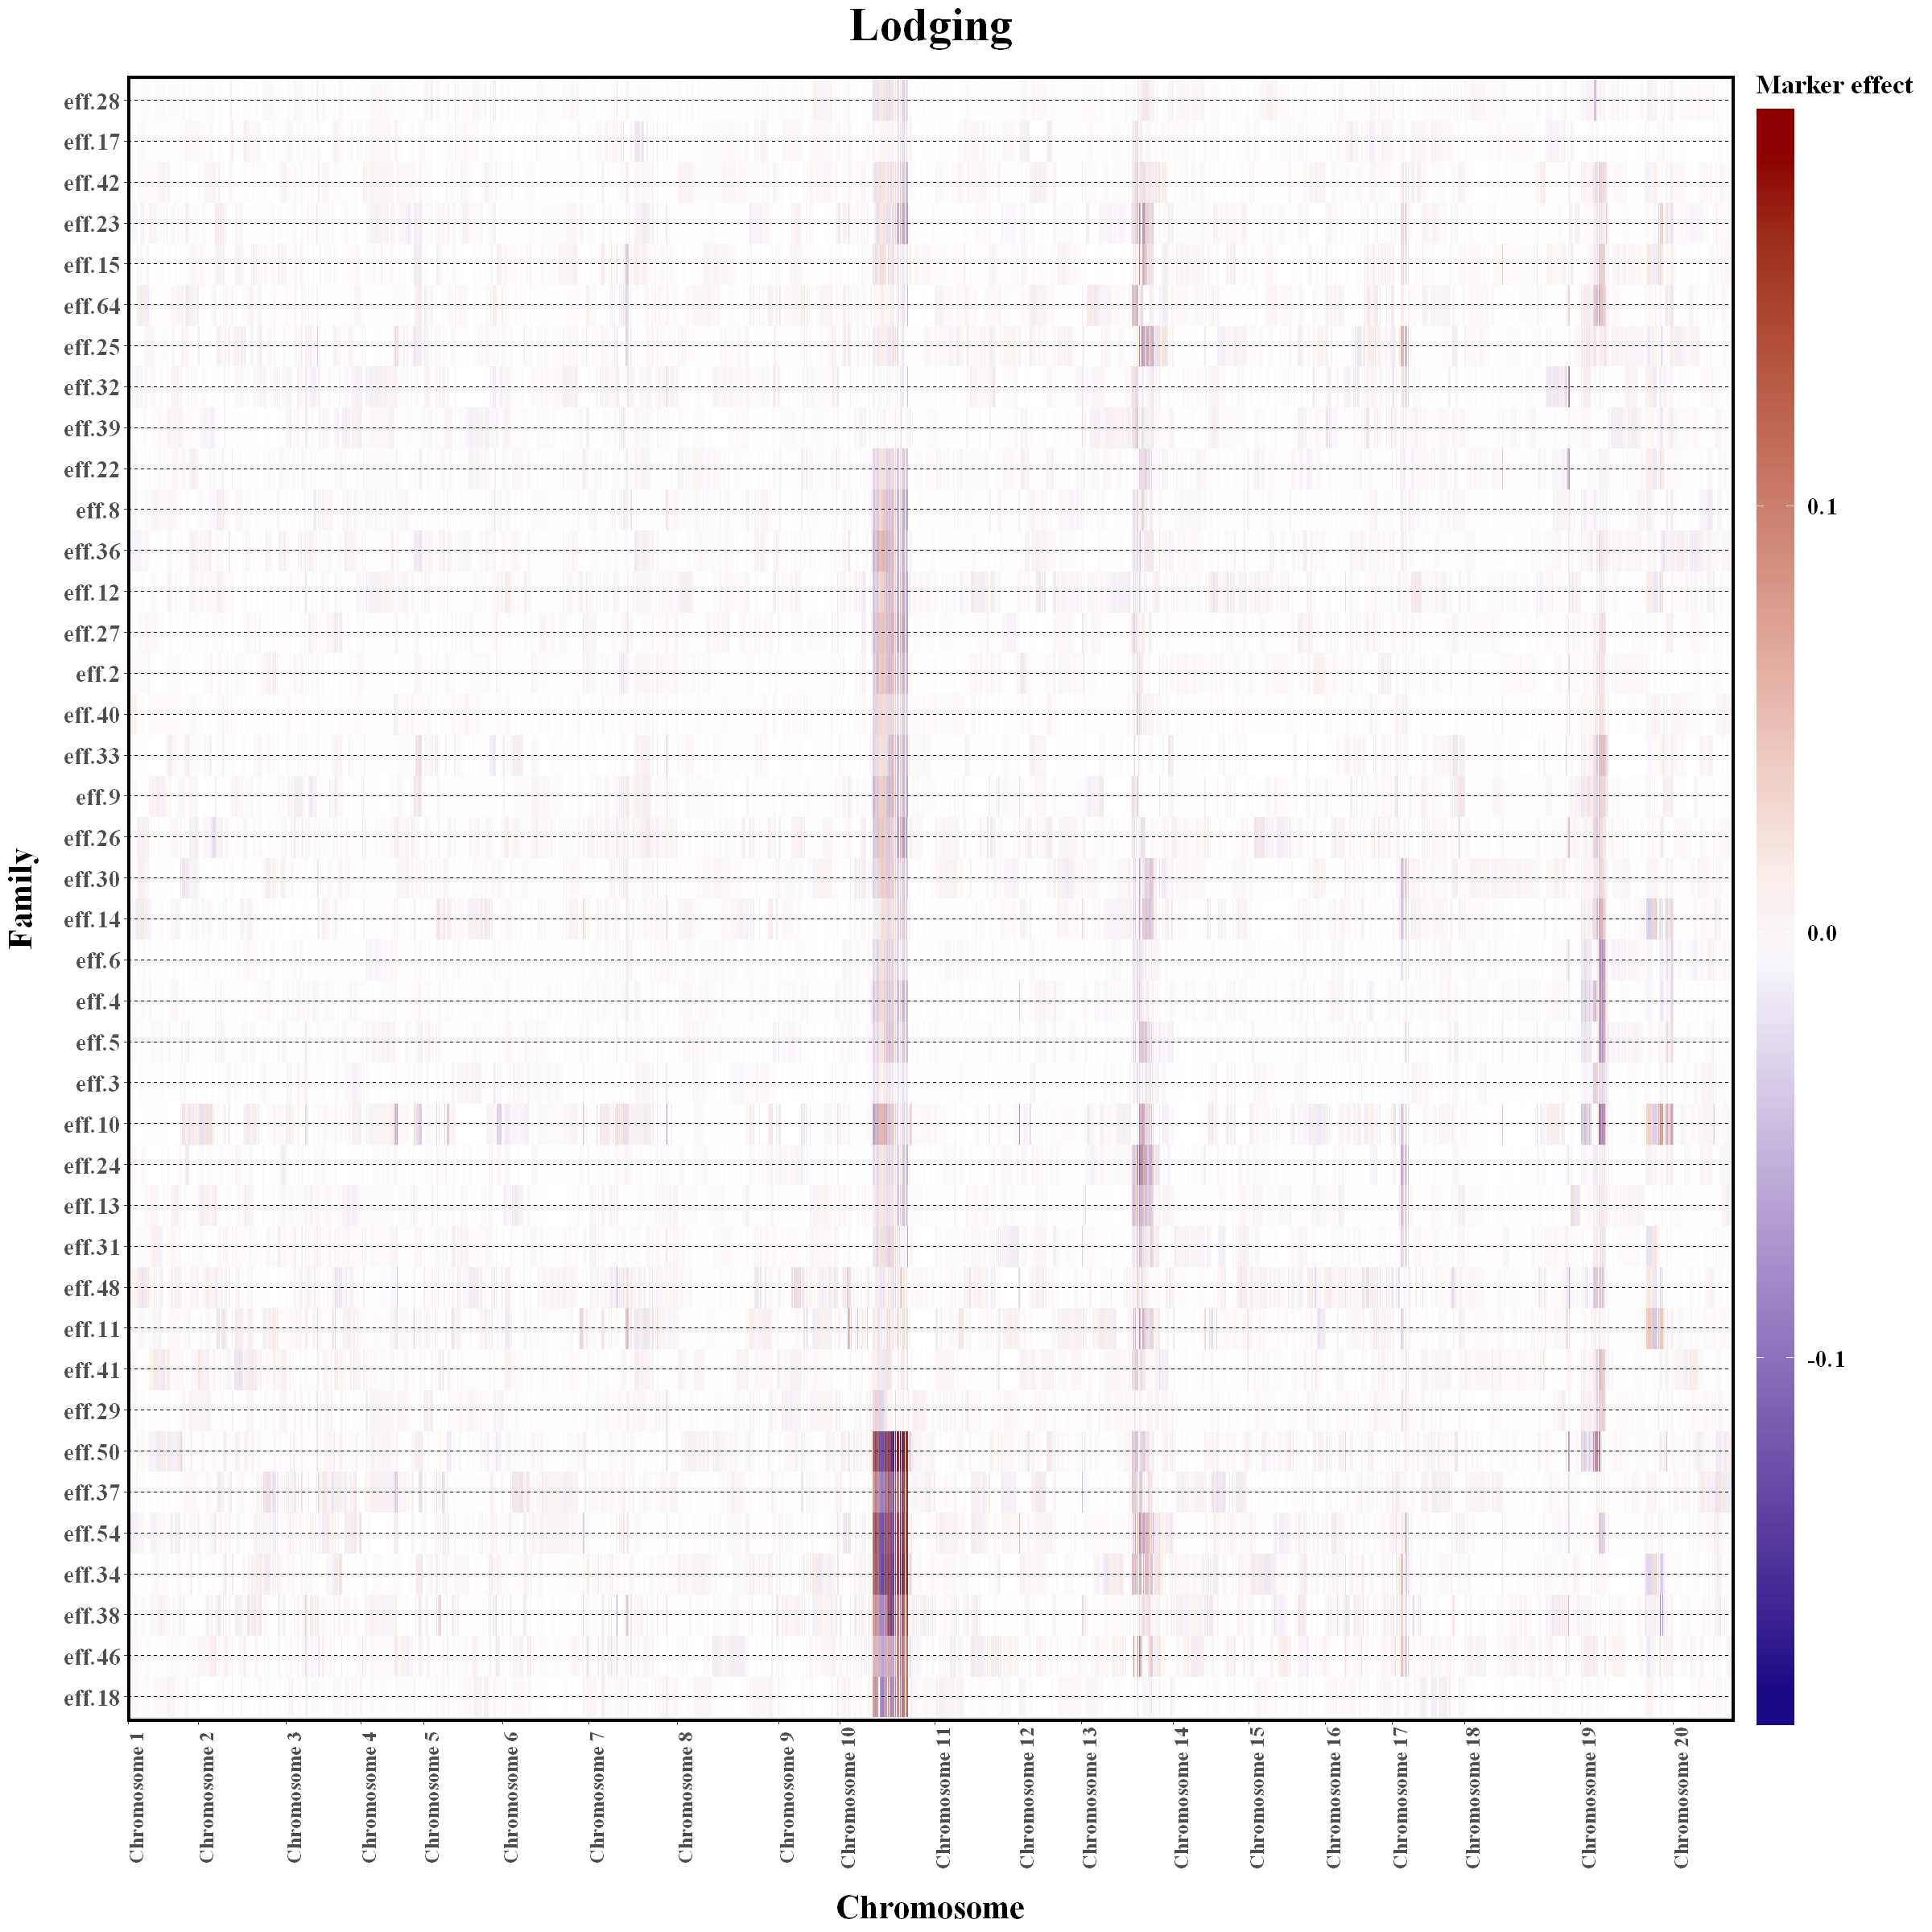

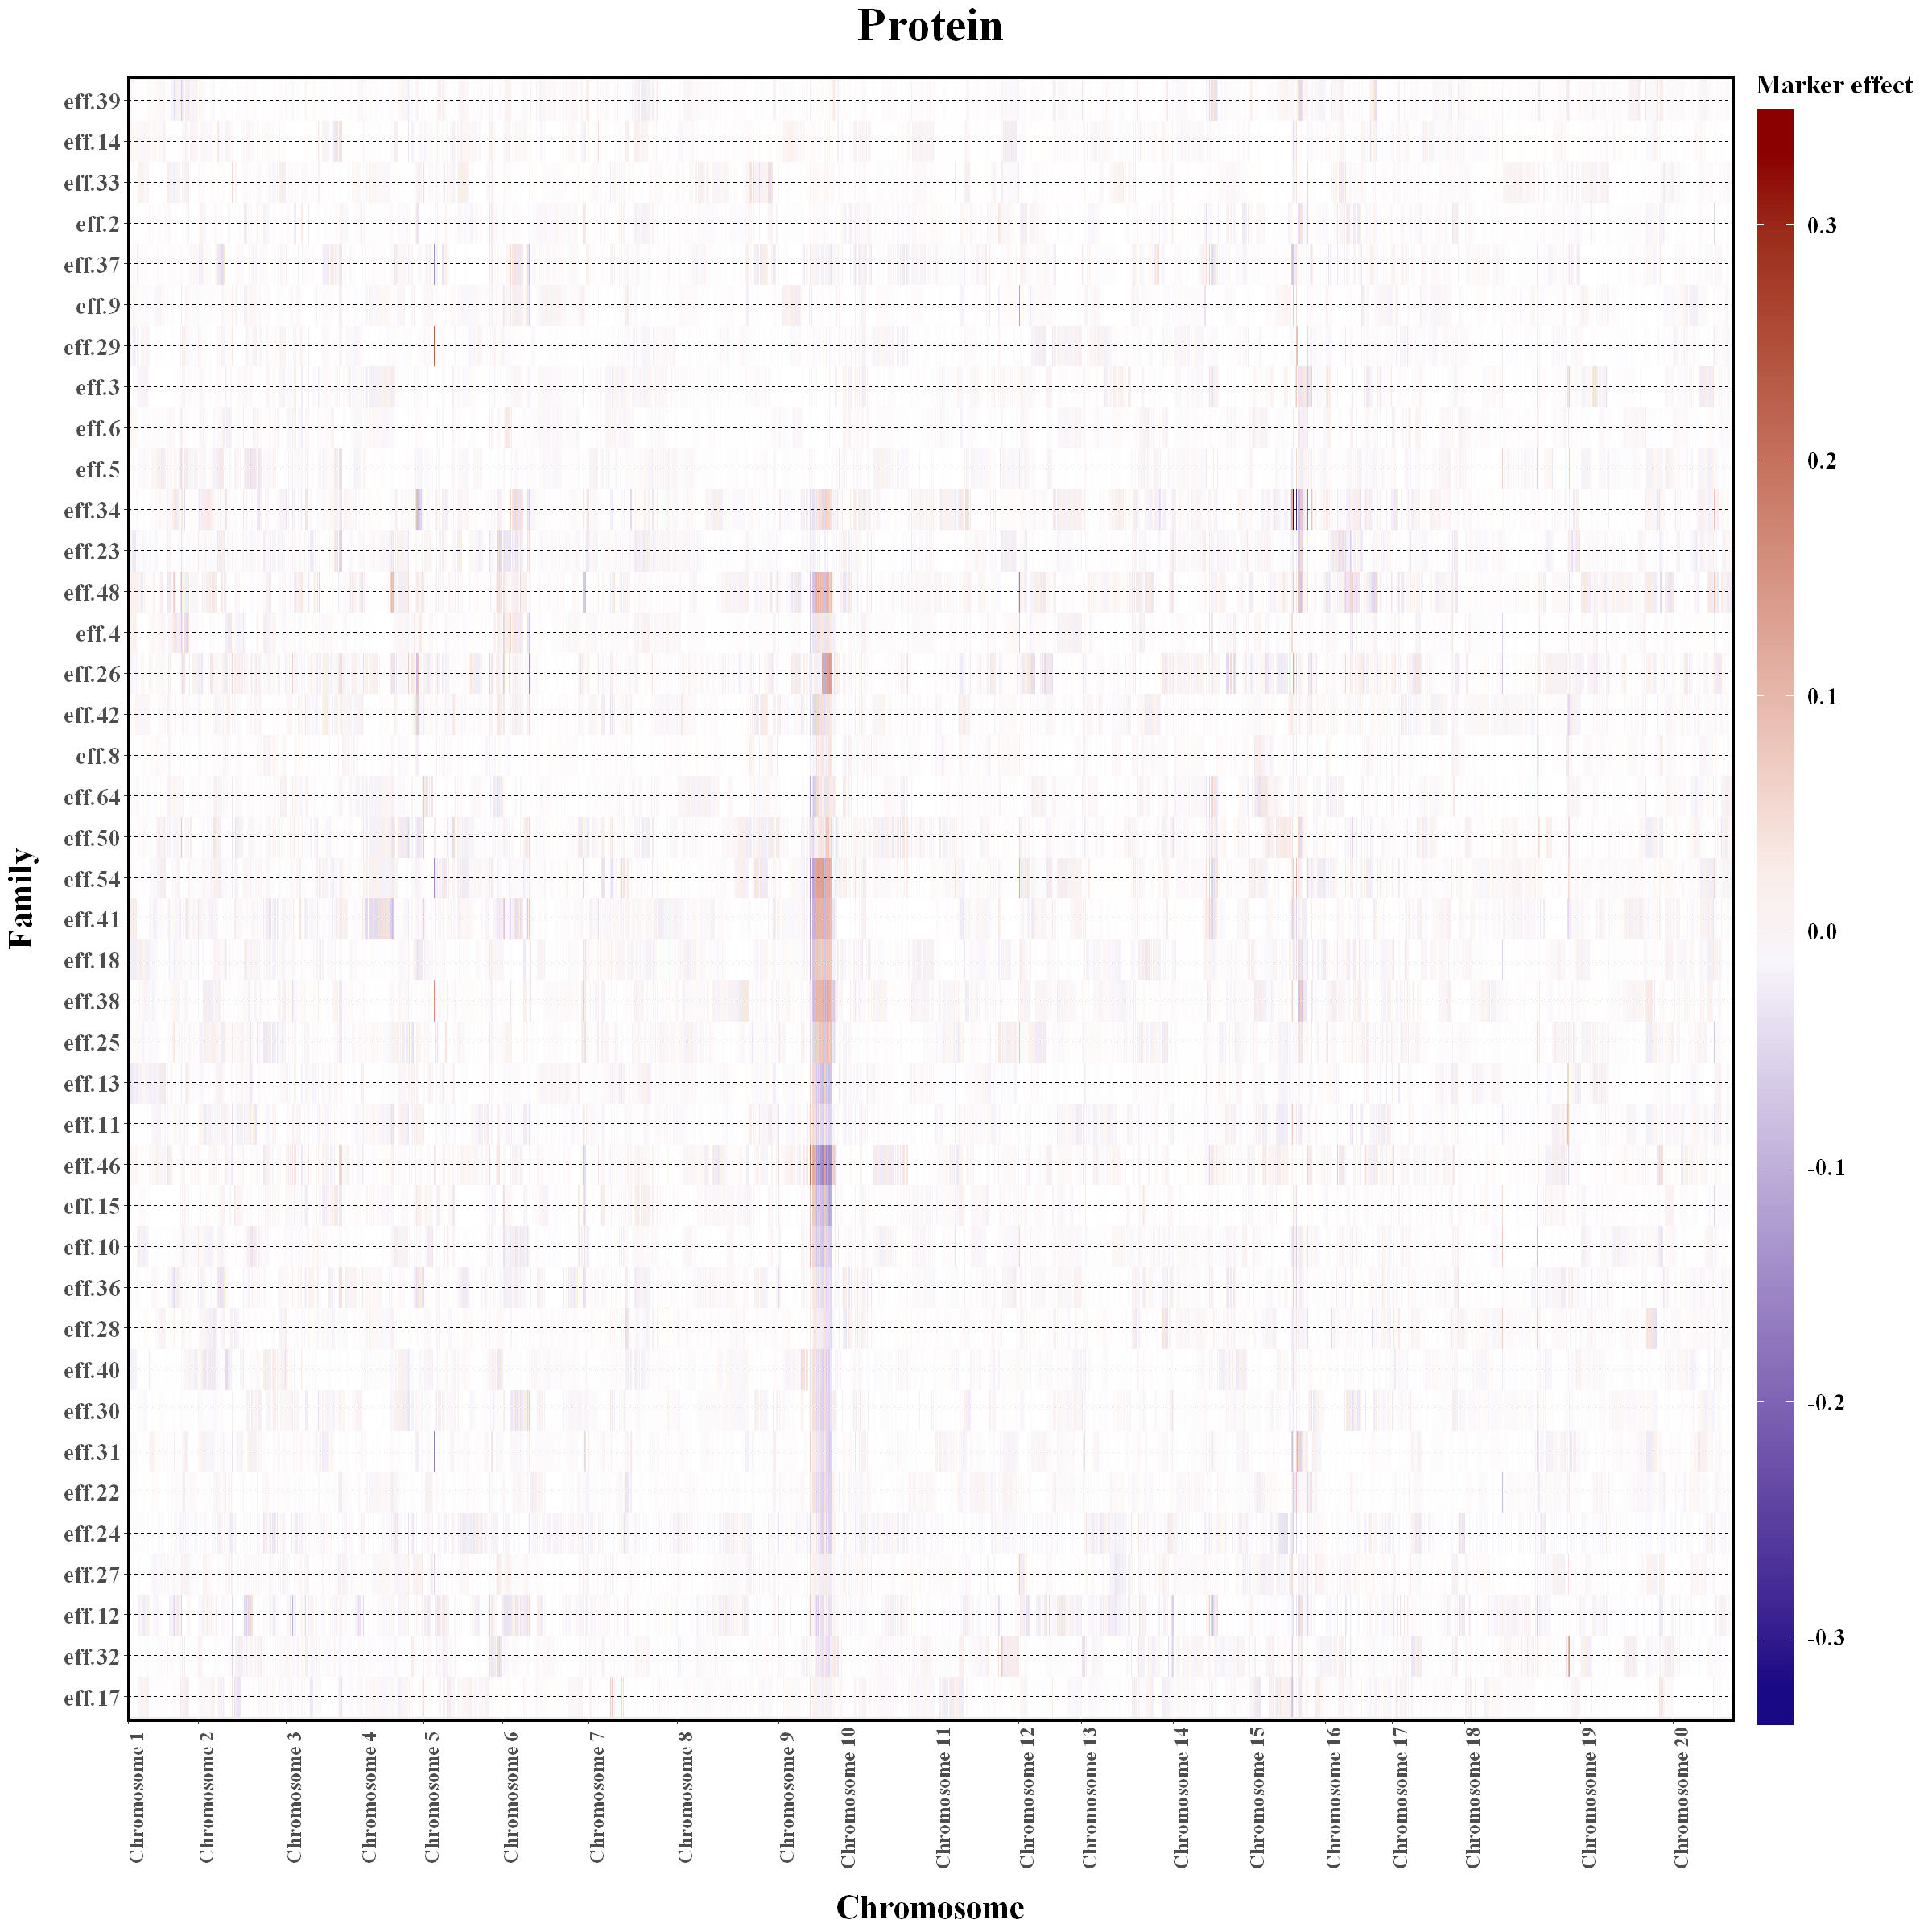

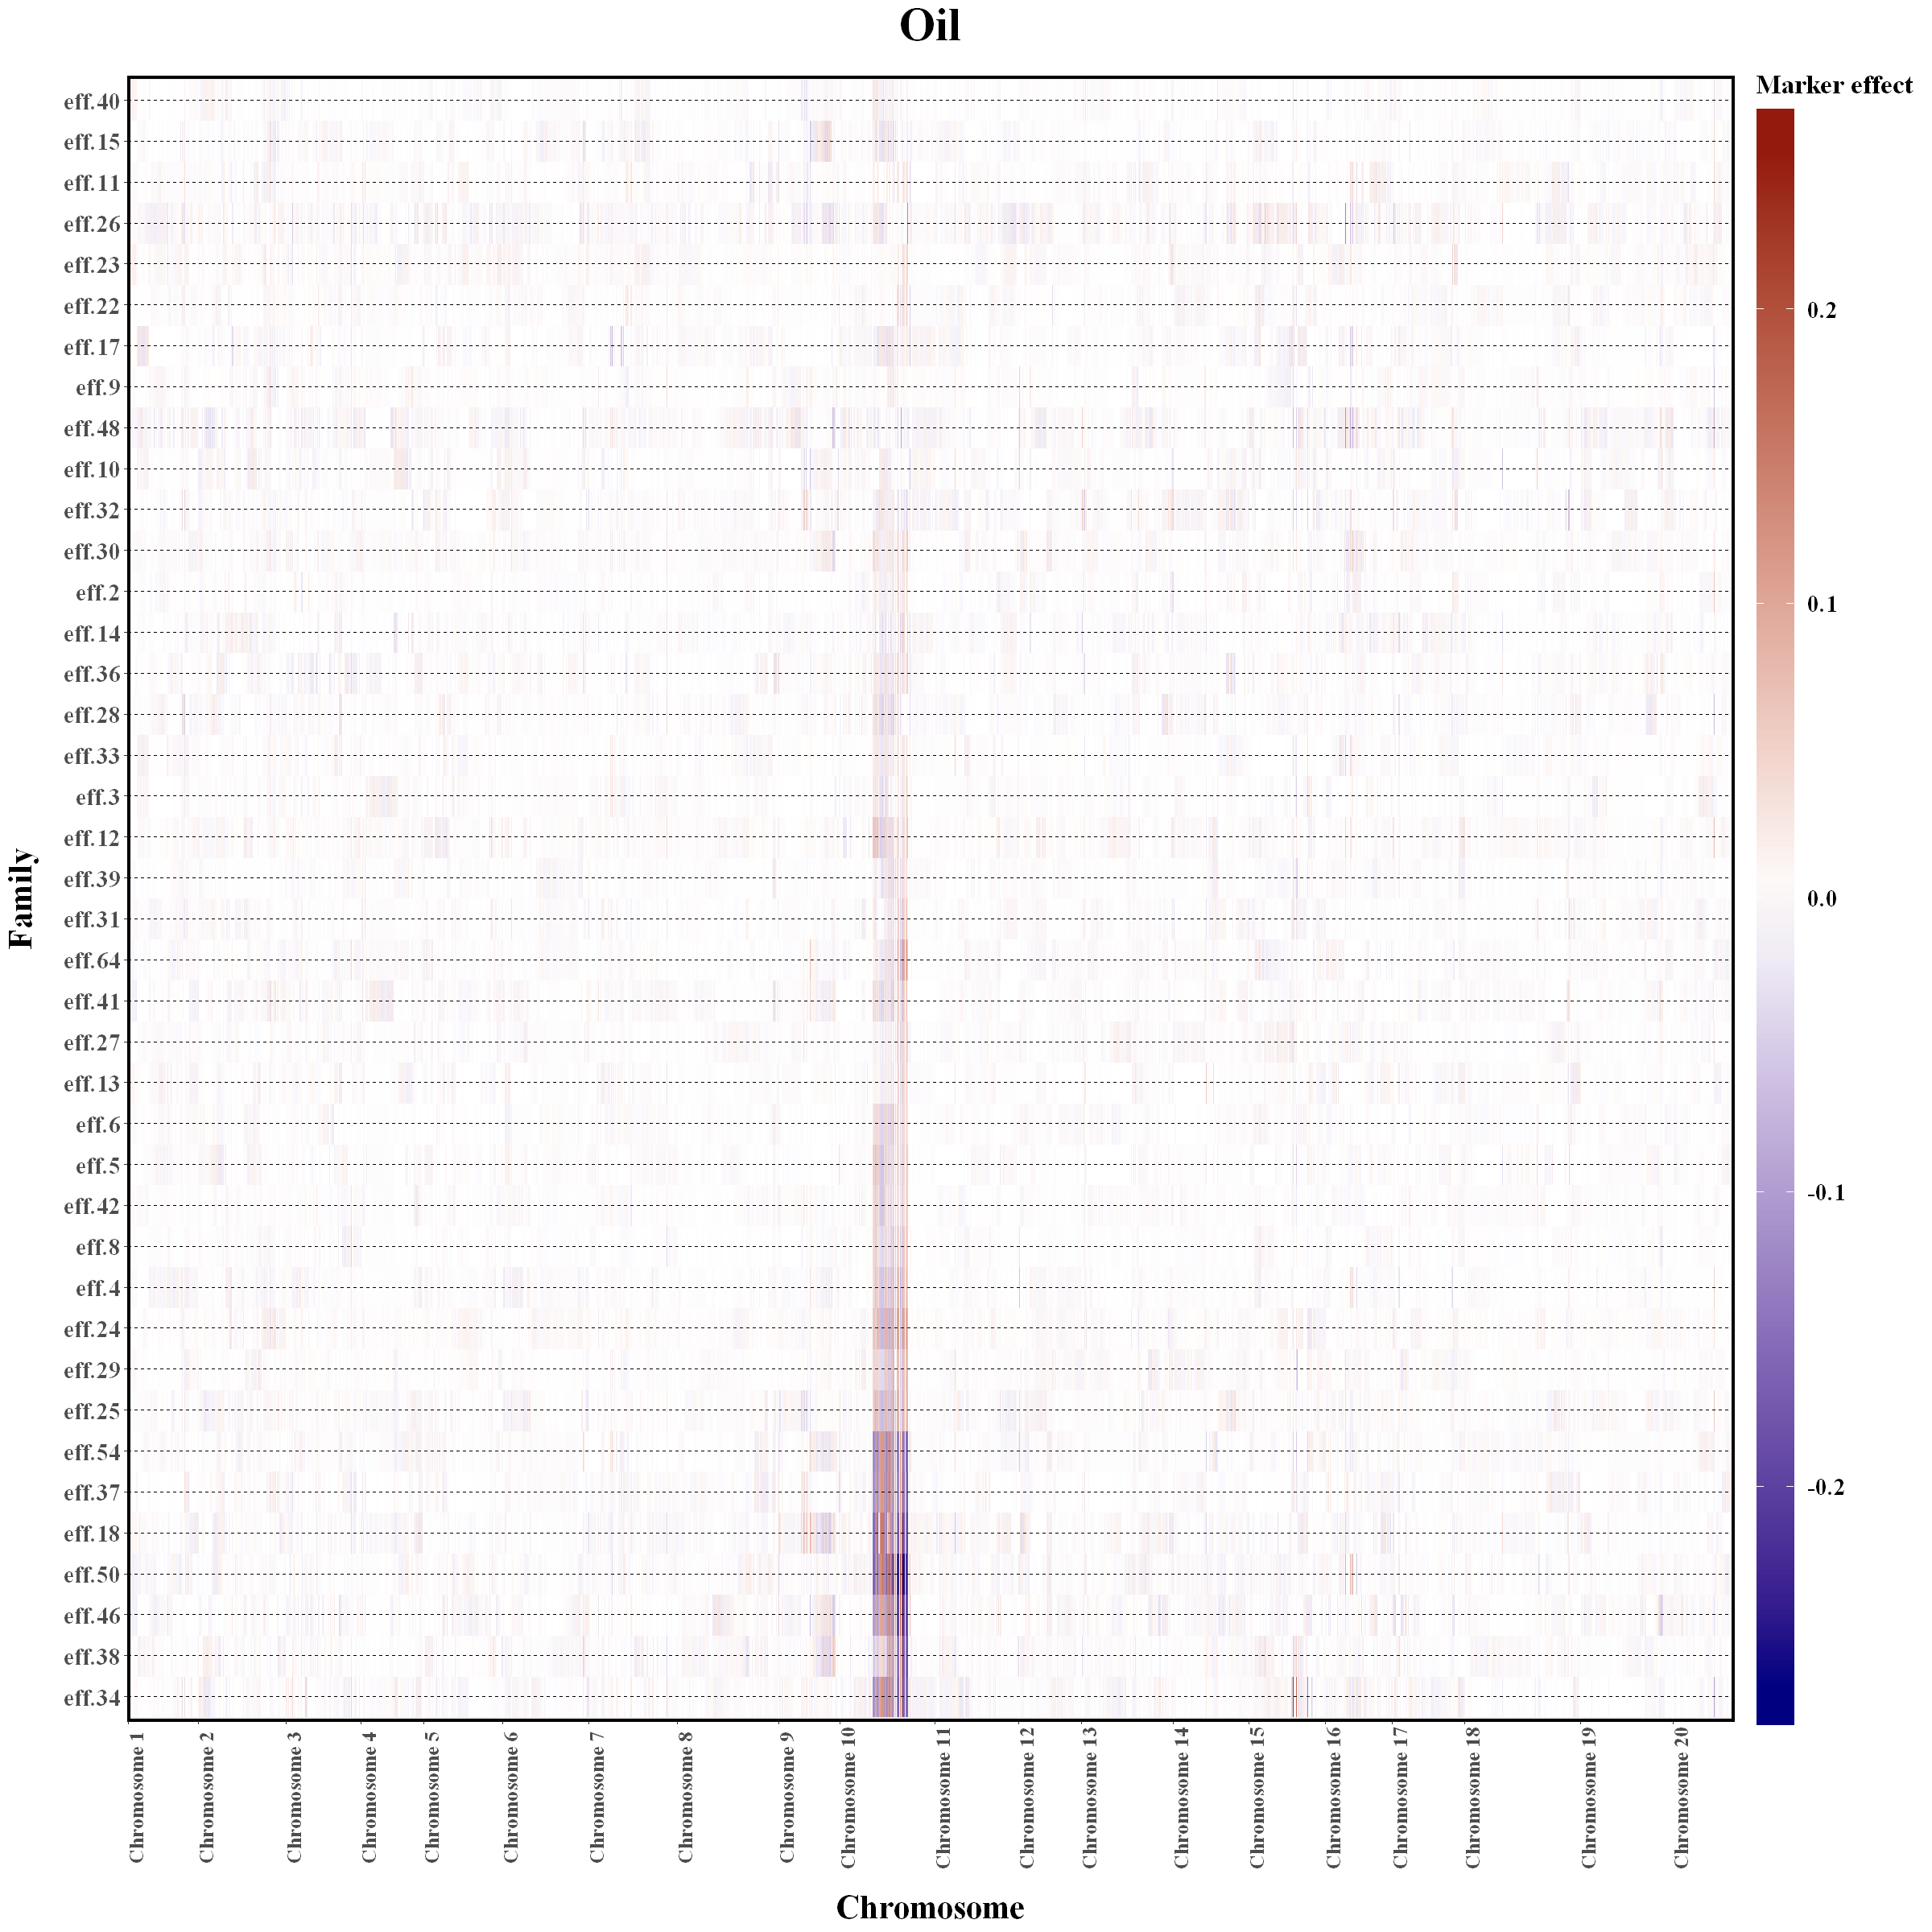

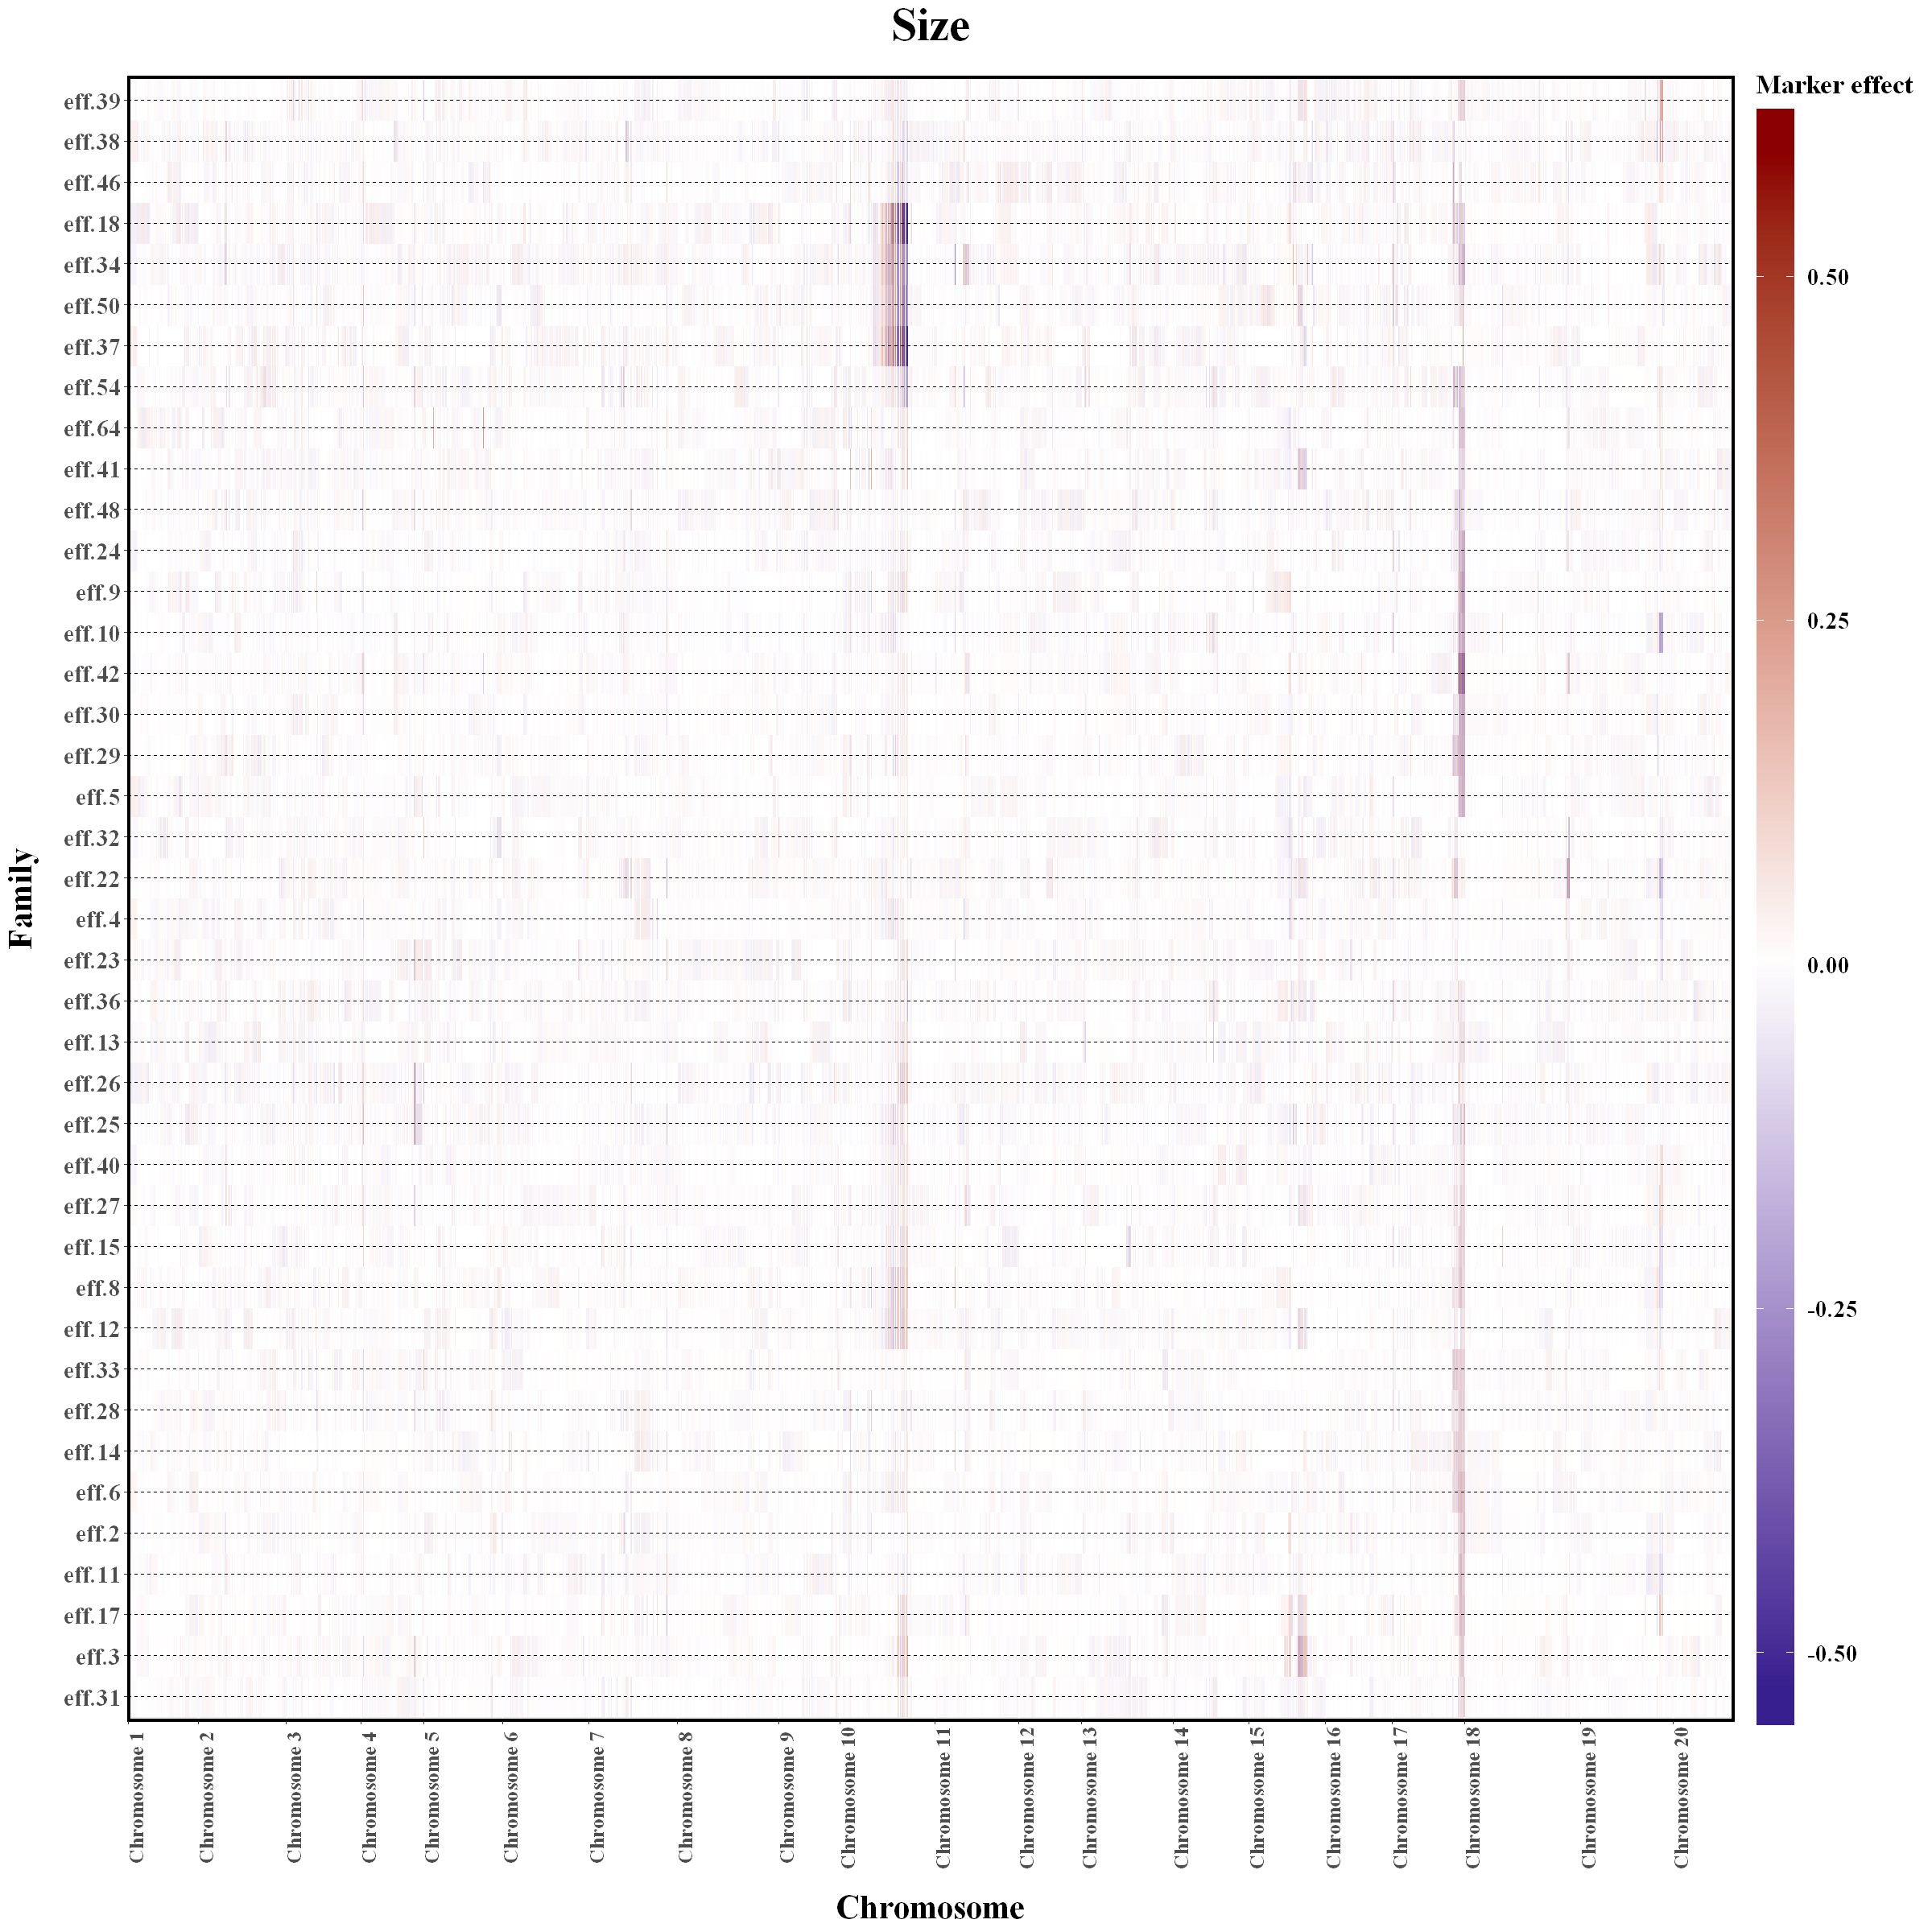

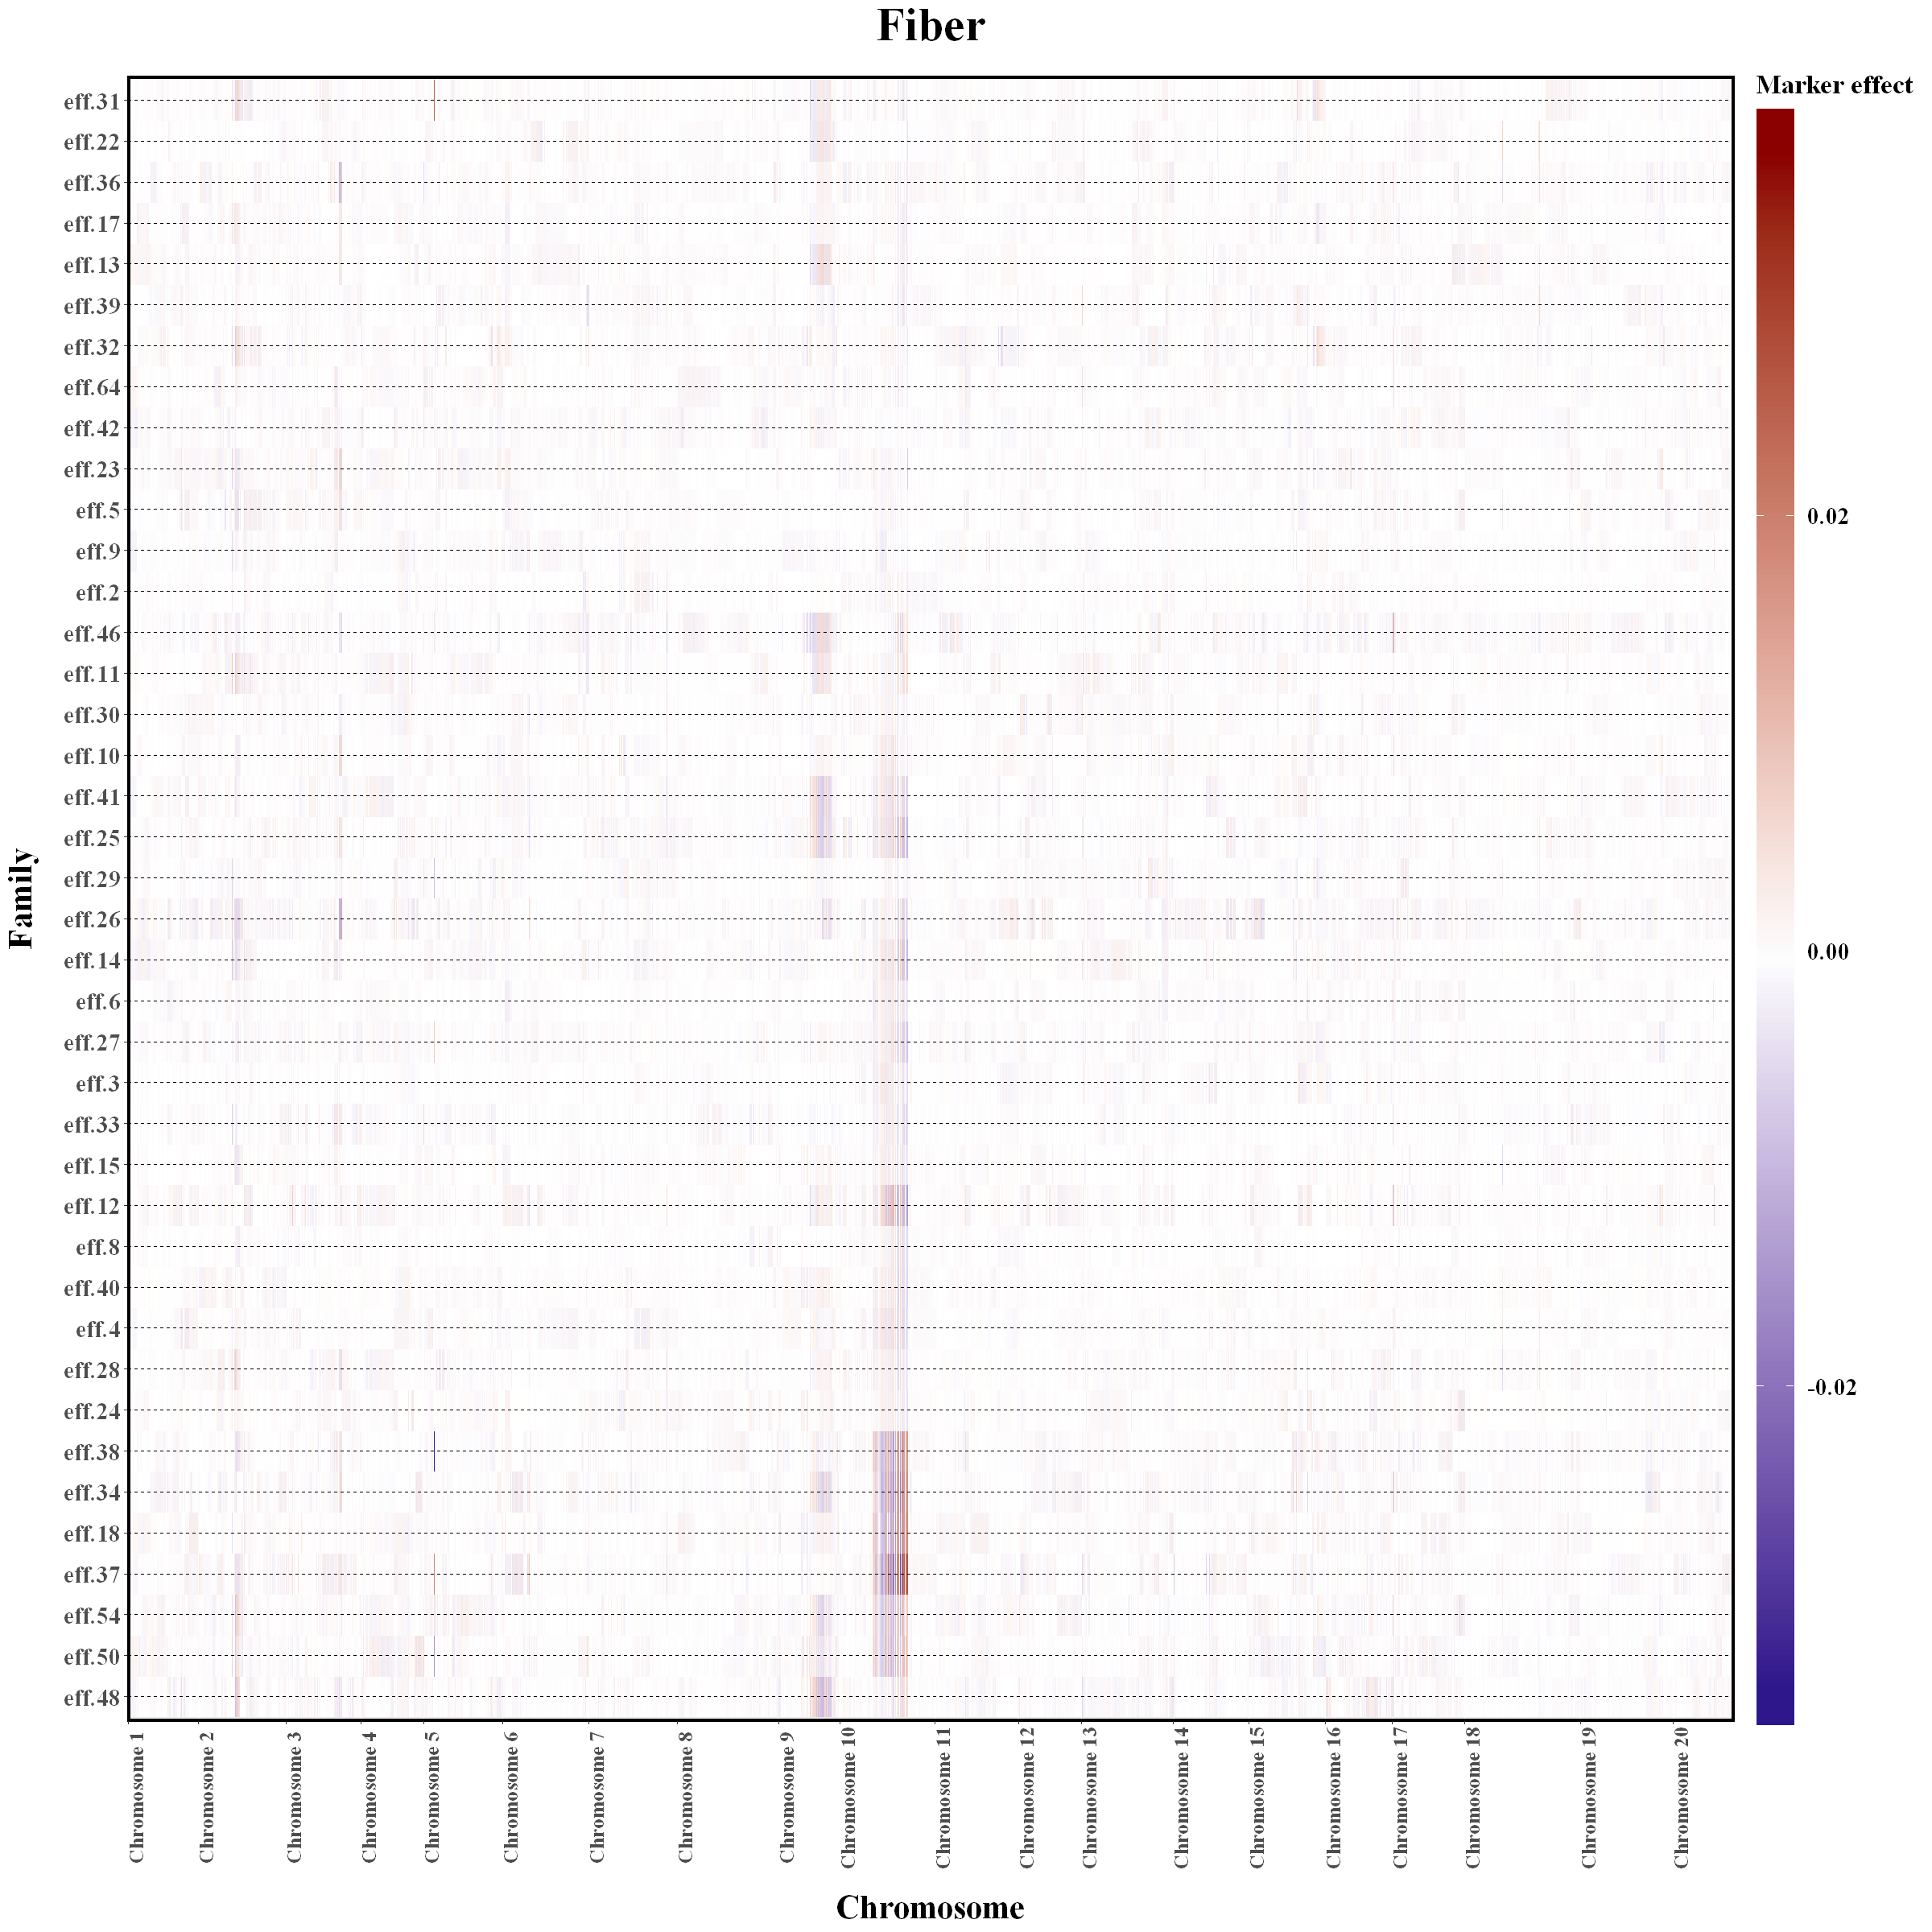

In [134]:
for(i in 1:length(PlotList)){
    plot(PlotList[[i]])
}

## Finally
This by no means is the only reasonable way to organize this data for plotting, it would be interesting to try to group the data furher by clustering among traits to try to narrow down traits to groups with similar genetic architecture. Finding a way to put all the traits in a single plot without it becoming overwhelming could be an interesting way to compare effects between traits. There are also plenty of colorschemes to choose from which may be more effective at highlighting significant markers than the one I'be gone with here. Either way, I hope someone else may find this a useful way for exploring similar data. Feel free to contact me at jhgille2@ncsu with any comments/improvements you can think of.